In [ ]:

# Knowledge Distillation 

# Setup:
# - Teacher: VGG-16 (pretrained on CIFAR-100 from pytorch-cifar-models)
# - Student: VGG-11 (train from scratch)
# - Dataset: CIFAR-100

# Important Notes on Model Architecture:
# - These VGG models are specifically designed for CIFAR-100 (32x32 images)
# - The pytorch-cifar-models repository provides models with:
#   * Same convolutional feature extractors as original VGG
#   * Modified classifier heads for CIFAR-100 (100 classes vs ImageNet's 1000)
#   * Smaller final FC layers due to smaller spatial dimensions (1x1x512 vs 7x7x512)


In [ ]:
"""
Knowledge Distillation Framework for CIFAR-100 - Logit Matching Variants, SoTA Comparison, Probability Distribution Analysis,
GradCAM Localization, Color Invariance, and Teacher Size Impact

"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
import cv2
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# DATA PREPARATION
# ============================================================================

def get_cifar100_dataloaders(batch_size=128, val_split=0.1, color_jitter=False):
    if color_jitter:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
    else:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    train_val_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test
    )

    val_size = int(len(train_val_dataset) * val_split)
    train_size = len(train_val_dataset) - val_size
    train_dataset, val_dataset = random_split(
        train_val_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

def get_color_jittered_loader(batch_size=128):
    transform_jitter = transforms.Compose([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    dataset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_jitter
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ============================================================================

def get_vgg_model(model_type='vgg11', num_classes=100, pretrained=False):
    if pretrained:
        if model_type == 'vgg11':
            model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True)
        elif model_type == 'vgg16':
            model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=True)
        elif model_type == 'vgg19':
            model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg19_bn", pretrained=True)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
    else:
        if model_type == 'vgg11':
            model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False)
        elif model_type == 'vgg16':
            model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=False)
        elif model_type == 'vgg19':
            model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg19_bn", pretrained=False)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
    return model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6

def evaluate_model(model, data_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(data_loader), 100. * correct / total

# TASK 1: LOGIT MATCHING VARIANTS

class LogitMatchingLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.5):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        ce_loss = self.ce_loss(student_logits, labels)
        soft_student = F.log_softmax(student_logits / self.temperature, dim=1)
        soft_teacher = F.softmax(teacher_logits / self.temperature, dim=1)
        kd_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (self.temperature ** 2)
        total_loss = self.alpha * ce_loss + (1 - self.alpha) * kd_loss
        return total_loss, ce_loss, kd_loss

class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes=100, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, logits, labels):
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, labels.unsqueeze(1), self.confidence)
        log_probs = F.log_softmax(logits, dim=1)
        loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))
        return loss
    
class DecoupledKDLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.7, beta=0.1): 
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha  
        self.beta = beta    
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        ce_loss = self.ce_loss(student_logits, labels)
        T = self.temperature

        student_probs = F.softmax(student_logits / T, dim=1)
        teacher_probs = F.softmax(teacher_logits / T, dim=1)

        batch_size = student_logits.size(0)
        target_mask = torch.zeros_like(student_probs)
        target_mask.scatter_(1, labels.unsqueeze(1), 1)

        student_target = (student_probs * target_mask).sum(dim=1)
        teacher_target = (teacher_probs * target_mask).sum(dim=1)
        tckd_loss = F.binary_cross_entropy(student_target, teacher_target, reduction='mean')

        non_target_mask = 1 - target_mask
        student_non_target = student_probs * non_target_mask
        teacher_non_target = teacher_probs * non_target_mask

        student_non_target = student_non_target / (student_non_target.sum(dim=1, keepdim=True) + 1e-8)
        teacher_non_target = teacher_non_target / (teacher_non_target.sum(dim=1, keepdim=True) + 1e-8)

        nckd_loss = F.kl_div(
            F.log_softmax(student_logits * non_target_mask / T, dim=1),
            F.softmax(teacher_logits * non_target_mask / T, dim=1),
            reduction='batchmean'
        )

        total_loss = self.alpha * ce_loss + self.beta * (tckd_loss + nckd_loss)

        return total_loss, ce_loss, tckd_loss, nckd_loss

def train_with_logit_matching(student, teacher, train_loader, val_loader, variant='basic', epochs=50, lr=0.1):
    student = student.to(device)
    teacher = teacher.to(device)
    teacher.eval()

    if variant == 'basic':
        criterion = LogitMatchingLoss(temperature=4.0, alpha=0.5)
    elif variant == 'label_smoothing':
        criterion = LabelSmoothingLoss(num_classes=100, smoothing=0.1)
    elif variant == 'dkd':
        criterion = DecoupledKDLoss(temperature=4.0, alpha=1.0, beta=8.0)
    else:
        raise ValueError(f"Unknown variant: {variant}")

    optimizer = optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 80], gamma=0.2)

    history = defaultdict(list)
    best_val_acc = 0.0

    for epoch in range(epochs):
        student.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [{variant}]')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_logits = student(inputs)

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            if variant == 'label_smoothing':
                loss = criterion(student_logits, labels)
            elif variant == 'basic':
                loss, ce_loss, kd_loss = criterion(student_logits, teacher_logits, labels)
            elif variant == 'dkd':
                loss, ce_loss, tckd_loss, nckd_loss = criterion(student_logits, teacher_logits, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = student_logits.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': f'{train_loss/(pbar.n+1):.4f}',
                            'acc': f'{100.*train_correct/train_total:.2f}%'})

        val_loss, val_acc = evaluate_model(student, val_loader)
        scheduler.step()

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(100. * train_correct / train_total)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), f'best_student_{variant}.pth')

        if epoch % 20 == 19:
            print(f'Epoch {epoch+1}: Train Acc: {100.*train_correct/train_total:.2f}%, Val Acc: {val_acc:.2f}%, Best: {best_val_acc:.2f}%')

    return student, history

def train_independent_student(model, train_loader, val_loader, epochs=50, lr=0.1):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 80], gamma=0.2)

    history = defaultdict(list)
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Independent]')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': f'{train_loss/(pbar.n+1):.4f}',
                            'acc': f'{100.*train_correct/train_total:.2f}%'})

        val_loss, val_acc = evaluate_model(model, val_loader)
        scheduler.step()

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(100. * train_correct / train_total)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_independent_student.pth')

        if epoch % 20 == 19:
            print(f'Epoch {epoch+1}: Train Acc: {100.*train_correct/train_total:.2f}%, Val Acc: {val_acc:.2f}%, Best: {best_val_acc:.2f}%')

    return model, history


Using device: cuda


In [ ]:

print("TASK 1: LOGIT MATCHING VARIANTS")

train_loader, val_loader, test_loader = get_cifar100_dataloaders(batch_size=128)
teacher = get_vgg_model('vgg16', pretrained=True)
teacher = teacher.to(device)
print(f"Teacher (VGG-16) parameters: {count_parameters(teacher):.2f}M")


TASK 1: LOGIT MATCHING VARIANTS


100%|██████████| 169M/169M [00:14<00:00, 11.9MB/s]


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg16_bn-7d8c4031.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg16_bn-7d8c4031.pt


100%|██████████| 58.4M/58.4M [00:01<00:00, 34.4MB/s]


Teacher (VGG-16) parameters: 15.30M


In [ ]:

print("\n[1/4] Training Independent Student...")
student_independent = get_vgg_model('vgg11', pretrained=False)
student_independent, hist_independent = train_independent_student(student_independent, train_loader, val_loader)

print("\n[2/4] Training with Basic Logit Matching...")
student_basic = get_vgg_model('vgg11', pretrained=False)
student_basic, hist_basic = train_with_logit_matching(student_basic, teacher, train_loader, val_loader, 'basic')

print("\n[3/4] Training with Label Smoothing...")
student_ls = get_vgg_model('vgg11', pretrained=False)
student_ls, hist_ls = train_with_logit_matching(student_ls, teacher, train_loader, val_loader, 'label_smoothing')

print("\n[4/4] Training with Decoupled KD...")
student_dkd = get_vgg_model('vgg11', pretrained=False)
student_dkd, hist_dkd = train_with_logit_matching(student_dkd, teacher, train_loader, val_loader, 'dkd')

teacher_acc = evaluate_model(teacher, val_loader)[1]
print(f"\nTask 1 Results:")
print(f"Teacher (VGG-16): {teacher_acc:.2f}%")
print(f"Independent Student: {max(hist_independent['val_acc']):.2f}%")
print(f"Basic Logit Matching: {max(hist_basic['val_acc']):.2f}%")
print(f"Label Smoothing: {max(hist_ls['val_acc']):.2f}%")
print(f"Decoupled KD: {max(hist_dkd['val_acc']):.2f}%")



[1/4] Training Independent Student...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Epoch 20/50 [Independent]: 100%|██████████| 352/352 [00:08<00:00, 39.53it/s, loss=2.3233, acc=40.32%]


Epoch 20: Train Acc: 40.32%, Val Acc: 34.62%, Best: 39.62%


Epoch 40/50 [Independent]: 100%|██████████| 352/352 [00:09<00:00, 38.96it/s, loss=1.1219, acc=69.04%]


Epoch 40: Train Acc: 69.04%, Val Acc: 57.82%, Best: 58.10%


Epoch 50/50 [Independent]: 100%|██████████| 352/352 [00:09<00:00, 38.23it/s, loss=0.9981, acc=72.50%]



[2/4] Training with Basic Logit Matching...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Epoch 20/50 [basic]: 100%|██████████| 352/352 [00:09<00:00, 38.60it/s, loss=7.9001, acc=35.69%]


Epoch 20: Train Acc: 35.69%, Val Acc: 34.04%, Best: 34.06%


Epoch 40/50 [basic]: 100%|██████████| 352/352 [00:08<00:00, 39.27it/s, loss=4.1384, acc=67.39%]


Epoch 40: Train Acc: 67.39%, Val Acc: 56.08%, Best: 56.84%


Epoch 50/50 [basic]: 100%|██████████| 352/352 [00:09<00:00, 37.68it/s, loss=3.6124, acc=71.85%]



[3/4] Training with Label Smoothing...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Epoch 20/50 [label_smoothing]: 100%|██████████| 352/352 [00:08<00:00, 39.27it/s, loss=2.6953, acc=42.86%]


Epoch 20: Train Acc: 42.86%, Val Acc: 39.98%, Best: 39.98%


Epoch 40/50 [label_smoothing]: 100%|██████████| 352/352 [00:09<00:00, 38.61it/s, loss=1.7242, acc=72.62%]


Epoch 40: Train Acc: 72.62%, Val Acc: 58.10%, Best: 59.50%


Epoch 50/50 [label_smoothing]: 100%|██████████| 352/352 [00:09<00:00, 39.10it/s, loss=1.6303, acc=76.06%]



[4/4] Training with Decoupled KD...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Epoch 20/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.45it/s, loss=79.5191, acc=1.36%]


Epoch 20: Train Acc: 1.36%, Val Acc: 1.36%, Best: 3.08%


Epoch 40/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.78it/s, loss=80.4405, acc=1.01%]


Epoch 40: Train Acc: 1.01%, Val Acc: 1.08%, Best: 3.08%


Epoch 50/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.17it/s, loss=80.7985, acc=0.99%]



Task 1 Results:
Teacher (VGG-16): 99.96%
Independent Student: 58.18%
Basic Logit Matching: 57.60%
Label Smoothing: 59.50%
Decoupled KD: 3.08%


---
DKD

In [ ]:
class DecoupledKDLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.7, beta=0.1): 
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha  
        self.beta = beta    
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        ce_loss = self.ce_loss(student_logits, labels)
        T = self.temperature

        student_probs = F.softmax(student_logits / T, dim=1)
        teacher_probs = F.softmax(teacher_logits / T, dim=1)

        batch_size = student_logits.size(0)
        target_mask = torch.zeros_like(student_probs)
        target_mask.scatter_(1, labels.unsqueeze(1), 1)

        student_target = (student_probs * target_mask).sum(dim=1)
        teacher_target = (teacher_probs * target_mask).sum(dim=1)
        tckd_loss = F.mse_loss(student_target, teacher_target)

        non_target_mask = 1 - target_mask
        student_non_target = student_probs * non_target_mask
        teacher_non_target = teacher_probs * non_target_mask

        nckd_loss = F.kl_div(
            F.log_softmax(student_logits * non_target_mask / T, dim=1),
            F.softmax(teacher_logits * non_target_mask / T, dim=1),
            reduction='batchmean'
        )

        total_loss = self.alpha * ce_loss + self.beta * (tckd_loss + nckd_loss)

        return total_loss, ce_loss, tckd_loss, nckd_loss

def train_with_logit_matching(student, teacher, train_loader, val_loader, variant='basic', epochs=50, lr=0.05):
    print(f"\n=== Starting {variant} training ===")

    student = student.to(device)
    teacher = teacher.to(device)
    teacher.eval()

    if variant == 'basic':
        criterion = LogitMatchingLoss(temperature=4.0, alpha=0.5)
    elif variant == 'label_smoothing':
        criterion = LabelSmoothingLoss(num_classes=100, smoothing=0.1)
    elif variant == 'dkd':
        criterion = DecoupledKDLoss(temperature=4.0, alpha=0.7, beta=0.1)  
    else:
        raise ValueError(f"Unknown variant: {variant}")

    optimizer = optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 40], gamma=0.2)

    history = defaultdict(list)
    best_val_acc = 0.0

    for epoch in range(epochs):
        student.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        epoch_start_time = torch.cuda.Event(enable_timing=True) if torch.cuda.is_available() else None
        if epoch_start_time:
            epoch_start_time.record()

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [{variant}]')

        try:
            for batch_idx, (inputs, labels) in enumerate(pbar):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                student_logits = student(inputs)

                with torch.no_grad():
                    teacher_logits = teacher(inputs)

                if variant == 'label_smoothing':
                    loss = criterion(student_logits, labels)
                elif variant == 'basic':
                    loss, ce_loss, kd_loss = criterion(student_logits, teacher_logits, labels)
                elif variant == 'dkd':
                    loss, ce_loss, tckd_loss, nckd_loss = criterion(student_logits, teacher_logits, labels)

                if torch.isnan(loss) or loss.item() > 100:
                    print(f"\nWARNING: Loss is {loss.item():.2f} at epoch {epoch+1}, batch {batch_idx}")
                    if variant == 'dkd':
                        print(f"  CE: {ce_loss.item():.4f}, TCKD: {tckd_loss.item():.4f}, NCKD: {nckd_loss.item():.4f}")
                    continue

                loss.backward()

                torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)

                optimizer.step()

                train_loss += loss.item()
                _, predicted = student_logits.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()

                if batch_idx % 50 == 0:
                    current_acc = 100. * train_correct / train_total if train_total > 0 else 0
                    pbar.set_postfix({
                        'loss': f'{loss.item():.3f}',
                        'avg_loss': f'{train_loss/(batch_idx+1):.3f}',
                        'acc': f'{current_acc:.1f}%'
                    })

        except Exception as e:
            print(f"Error during training at epoch {epoch+1}: {e}")
            break

        try:
            val_loss, val_acc = evaluate_model(student, val_loader)
            scheduler.step()

            history['train_loss'].append(train_loss / len(train_loader))
            history['train_acc'].append(100. * train_correct / train_total)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(student.state_dict(), f'best_student_{variant}.pth')

            print(f'Epoch {epoch+1}: Loss: {train_loss/len(train_loader):.3f}, '
                  f'Train Acc: {100.*train_correct/train_total:.2f}%, '
                  f'Val Acc: {val_acc:.2f}%, Best: {best_val_acc:.2f}%')

            if train_loss / len(train_loader) > 20:
                print(f"Stopping early due to high loss: {train_loss/len(train_loader):.2f}")
                break

        except Exception as e:
            print(f"Error during validation at epoch {epoch+1}: {e}")
            break

    print(f"=== Finished {variant} training ===\n")
    return student, history

print("Testing DKD loss computation...")
try:
    student_logits = torch.randn(32, 100)  
    teacher_logits = torch.randn(32, 100)
    labels = torch.randint(0, 100, (32,))

    dkd_criterion = DecoupledKDLoss(temperature=4.0, alpha=0.7, beta=0.1)
    loss, ce_loss, tckd_loss, nckd_loss = dkd_criterion(student_logits, teacher_logits, labels)

    print(f"Test DKD Loss: {loss.item():.4f}")
    print(f"  CE: {ce_loss.item():.4f}")
    print(f"  TCKD: {tckd_loss.item():.4f}")
    print(f"  NCKD: {nckd_loss.item():.4f}")

    if loss.item() < 10:
        print("✓ DKD loss looks reasonable")
    else:
        print("✗ DKD loss is too high!")

except Exception as e:
    print(f"Error in DKD test: {e}")

print("="*80)

print("\n[4/4] Training with Decoupled KD (Fixed)...")
student_dkd = get_vgg_model('vgg11', pretrained=False)
student_dkd, hist_dkd = train_with_logit_matching(student_dkd, teacher, train_loader, val_loader, 'dkd', epochs=50, lr=0.1)

print(f"Decoupled KD: {max(hist_dkd['val_acc']):.2f}%")

Testing DKD loss computation...
Test DKD Loss: 3.6934
  CE: 5.2677
  TCKD: 0.0000
  NCKD: 0.0601
✓ DKD loss looks reasonable

[4/4] Training with Decoupled KD (Fixed)...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



=== Starting dkd training ===


Epoch 1/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 37.92it/s, loss=3.112, avg_loss=3.136, acc=2.3%]


Epoch 1: Loss: 3.136, Train Acc: 2.31%, Val Acc: 2.86%, Best: 2.86%


Epoch 2/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 40.06it/s, loss=2.829, avg_loss=2.944, acc=4.8%]


Epoch 2: Loss: 2.944, Train Acc: 4.79%, Val Acc: 8.16%, Best: 8.16%


Epoch 3/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.60it/s, loss=2.686, avg_loss=2.783, acc=7.4%]


Epoch 3: Loss: 2.783, Train Acc: 7.41%, Val Acc: 10.02%, Best: 10.02%


Epoch 4/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.30it/s, loss=2.714, avg_loss=2.609, acc=10.7%]


Epoch 4: Loss: 2.608, Train Acc: 10.73%, Val Acc: 10.40%, Best: 10.40%


Epoch 5/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 37.65it/s, loss=2.208, avg_loss=2.441, acc=14.7%]


Epoch 5: Loss: 2.440, Train Acc: 14.71%, Val Acc: 17.06%, Best: 17.06%


Epoch 6/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.30it/s, loss=2.294, avg_loss=2.303, acc=18.2%]


Epoch 6: Loss: 2.303, Train Acc: 18.17%, Val Acc: 18.60%, Best: 18.60%


Epoch 7/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.13it/s, loss=2.200, avg_loss=2.184, acc=21.5%]


Epoch 7: Loss: 2.184, Train Acc: 21.51%, Val Acc: 25.64%, Best: 25.64%


Epoch 8/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.69it/s, loss=2.059, avg_loss=2.078, acc=24.9%]


Epoch 8: Loss: 2.078, Train Acc: 24.94%, Val Acc: 27.04%, Best: 27.04%


Epoch 9/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.24it/s, loss=2.083, avg_loss=1.975, acc=28.0%]


Epoch 9: Loss: 1.975, Train Acc: 28.01%, Val Acc: 31.24%, Best: 31.24%


Epoch 10/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.64it/s, loss=1.797, avg_loss=1.897, acc=30.9%]


Epoch 10: Loss: 1.897, Train Acc: 30.90%, Val Acc: 31.04%, Best: 31.24%


Epoch 11/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.14it/s, loss=1.935, avg_loss=1.820, acc=33.2%]


Epoch 11: Loss: 1.820, Train Acc: 33.22%, Val Acc: 33.44%, Best: 33.44%


Epoch 12/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 39.08it/s, loss=1.752, avg_loss=1.764, acc=35.4%]


Epoch 12: Loss: 1.764, Train Acc: 35.44%, Val Acc: 35.30%, Best: 35.30%


Epoch 13/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 37.25it/s, loss=1.779, avg_loss=1.720, acc=36.9%]


Epoch 13: Loss: 1.720, Train Acc: 36.90%, Val Acc: 34.66%, Best: 35.30%


Epoch 14/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.70it/s, loss=1.618, avg_loss=1.681, acc=38.7%]


Epoch 14: Loss: 1.680, Train Acc: 38.72%, Val Acc: 39.18%, Best: 39.18%


Epoch 15/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.89it/s, loss=1.858, avg_loss=1.637, acc=40.3%]


Epoch 15: Loss: 1.638, Train Acc: 40.31%, Val Acc: 38.08%, Best: 39.18%


Epoch 16/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.68it/s, loss=1.459, avg_loss=1.336, acc=49.8%]


Epoch 16: Loss: 1.336, Train Acc: 49.82%, Val Acc: 51.46%, Best: 51.46%


Epoch 17/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.53it/s, loss=1.103, avg_loss=1.221, acc=53.7%]


Epoch 17: Loss: 1.220, Train Acc: 53.70%, Val Acc: 52.60%, Best: 52.60%


Epoch 18/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.59it/s, loss=1.099, avg_loss=1.160, acc=55.9%]


Epoch 18: Loss: 1.161, Train Acc: 55.87%, Val Acc: 52.96%, Best: 52.96%


Epoch 19/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.98it/s, loss=1.128, avg_loss=1.106, acc=57.9%]


Epoch 19: Loss: 1.106, Train Acc: 57.84%, Val Acc: 54.36%, Best: 54.36%


Epoch 20/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.90it/s, loss=1.062, avg_loss=1.063, acc=59.6%]


Epoch 20: Loss: 1.064, Train Acc: 59.55%, Val Acc: 54.88%, Best: 54.88%


Epoch 21/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.96it/s, loss=0.939, avg_loss=1.019, acc=60.9%]


Epoch 21: Loss: 1.019, Train Acc: 60.94%, Val Acc: 55.88%, Best: 55.88%


Epoch 22/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 37.06it/s, loss=0.904, avg_loss=0.990, acc=62.2%]


Epoch 22: Loss: 0.990, Train Acc: 62.25%, Val Acc: 55.76%, Best: 55.88%


Epoch 23/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 39.06it/s, loss=0.921, avg_loss=0.950, acc=63.7%]


Epoch 23: Loss: 0.950, Train Acc: 63.68%, Val Acc: 55.90%, Best: 55.90%


Epoch 24/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.58it/s, loss=0.889, avg_loss=0.925, acc=64.7%]


Epoch 24: Loss: 0.925, Train Acc: 64.68%, Val Acc: 56.18%, Best: 56.18%


Epoch 25/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.17it/s, loss=0.993, avg_loss=0.886, acc=66.1%]


Epoch 25: Loss: 0.886, Train Acc: 66.14%, Val Acc: 56.76%, Best: 56.76%


Epoch 26/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.47it/s, loss=0.872, avg_loss=0.861, acc=67.0%]


Epoch 26: Loss: 0.861, Train Acc: 67.00%, Val Acc: 55.88%, Best: 56.76%


Epoch 27/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.67it/s, loss=0.895, avg_loss=0.835, acc=68.2%]


Epoch 27: Loss: 0.835, Train Acc: 68.15%, Val Acc: 57.34%, Best: 57.34%


Epoch 28/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 39.02it/s, loss=0.812, avg_loss=0.812, acc=68.9%]


Epoch 28: Loss: 0.812, Train Acc: 68.95%, Val Acc: 57.62%, Best: 57.62%


Epoch 29/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.95it/s, loss=0.663, avg_loss=0.784, acc=70.4%]


Epoch 29: Loss: 0.785, Train Acc: 70.42%, Val Acc: 57.74%, Best: 57.74%


Epoch 30/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.48it/s, loss=0.825, avg_loss=0.771, acc=71.0%]


Epoch 30: Loss: 0.772, Train Acc: 70.95%, Val Acc: 57.90%, Best: 57.90%


Epoch 31/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 40.36it/s, loss=0.531, avg_loss=0.639, acc=76.1%]


Epoch 31: Loss: 0.639, Train Acc: 76.08%, Val Acc: 61.14%, Best: 61.14%


Epoch 32/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 40.00it/s, loss=0.527, avg_loss=0.590, acc=78.0%]


Epoch 32: Loss: 0.590, Train Acc: 78.03%, Val Acc: 61.34%, Best: 61.34%


Epoch 33/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 40.05it/s, loss=0.493, avg_loss=0.556, acc=79.4%]


Epoch 33: Loss: 0.556, Train Acc: 79.43%, Val Acc: 61.24%, Best: 61.34%


Epoch 34/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.21it/s, loss=0.477, avg_loss=0.538, acc=80.3%]


Epoch 34: Loss: 0.538, Train Acc: 80.26%, Val Acc: 61.72%, Best: 61.72%


Epoch 35/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.99it/s, loss=0.483, avg_loss=0.521, acc=80.8%]


Epoch 35: Loss: 0.521, Train Acc: 80.77%, Val Acc: 61.42%, Best: 61.72%


Epoch 36/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.69it/s, loss=0.548, avg_loss=0.502, acc=81.8%]


Epoch 36: Loss: 0.502, Train Acc: 81.76%, Val Acc: 61.82%, Best: 61.82%


Epoch 37/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.16it/s, loss=0.559, avg_loss=0.490, acc=82.0%]


Epoch 37: Loss: 0.490, Train Acc: 81.97%, Val Acc: 61.48%, Best: 61.82%


Epoch 38/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.52it/s, loss=0.466, avg_loss=0.470, acc=82.9%]


Epoch 38: Loss: 0.470, Train Acc: 82.95%, Val Acc: 61.58%, Best: 61.82%


Epoch 39/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 37.46it/s, loss=0.453, avg_loss=0.463, acc=83.1%]


Epoch 39: Loss: 0.463, Train Acc: 83.11%, Val Acc: 61.64%, Best: 61.82%


Epoch 40/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.47it/s, loss=0.475, avg_loss=0.447, acc=83.9%]


Epoch 40: Loss: 0.447, Train Acc: 83.89%, Val Acc: 61.24%, Best: 61.82%


Epoch 41/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.35it/s, loss=0.342, avg_loss=0.419, acc=85.1%]


Epoch 41: Loss: 0.419, Train Acc: 85.14%, Val Acc: 62.44%, Best: 62.44%


Epoch 42/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.88it/s, loss=0.356, avg_loss=0.410, acc=85.5%]


Epoch 42: Loss: 0.410, Train Acc: 85.49%, Val Acc: 61.62%, Best: 62.44%


Epoch 43/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 40.05it/s, loss=0.490, avg_loss=0.407, acc=85.6%]


Epoch 43: Loss: 0.407, Train Acc: 85.62%, Val Acc: 62.30%, Best: 62.44%


Epoch 44/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.74it/s, loss=0.471, avg_loss=0.395, acc=86.2%]


Epoch 44: Loss: 0.395, Train Acc: 86.20%, Val Acc: 61.84%, Best: 62.44%


Epoch 45/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 36.91it/s, loss=0.386, avg_loss=0.393, acc=86.3%]


Epoch 45: Loss: 0.393, Train Acc: 86.34%, Val Acc: 61.52%, Best: 62.44%


Epoch 46/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.69it/s, loss=0.399, avg_loss=0.391, acc=86.3%]


Epoch 46: Loss: 0.391, Train Acc: 86.33%, Val Acc: 62.52%, Best: 62.52%


Epoch 47/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 40.21it/s, loss=0.400, avg_loss=0.384, acc=86.7%]


Epoch 47: Loss: 0.384, Train Acc: 86.73%, Val Acc: 61.92%, Best: 62.52%


Epoch 48/50 [dkd]: 100%|██████████| 352/352 [00:09<00:00, 38.95it/s, loss=0.453, avg_loss=0.385, acc=86.6%]


Epoch 48: Loss: 0.384, Train Acc: 86.57%, Val Acc: 62.22%, Best: 62.52%


Epoch 49/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.13it/s, loss=0.339, avg_loss=0.380, acc=86.7%]


Epoch 49: Loss: 0.380, Train Acc: 86.66%, Val Acc: 62.80%, Best: 62.80%


Epoch 50/50 [dkd]: 100%|██████████| 352/352 [00:08<00:00, 39.69it/s, loss=0.486, avg_loss=0.375, acc=87.2%]


Epoch 50: Loss: 0.375, Train Acc: 87.24%, Val Acc: 61.88%, Best: 62.80%
=== Finished dkd training ===

Decoupled KD: 62.80%


In [ ]:
student_independent = student_independent.to(device)
student_basic = student_basic.to(device)
student_ls = student_ls.to(device)
student_dkd = student_dkd.to(device)

try:
    student_independent.load_state_dict(torch.load('best_independent_student.pth'))
    student_basic.load_state_dict(torch.load('best_student_basic.pth'))
    student_ls.load_state_dict(torch.load('best_student_label_smoothing.pth'))
    student_dkd.load_state_dict(torch.load('best_student_dkd.pth'))
    print("Loaded best model checkpoints.")
except FileNotFoundError:
    print("Using final training states (checkpoints not found).")


print("FINAL RESULTS ON TEST SET")

teacher_test_acc = evaluate_model(teacher, test_loader)[1]
independent_test_acc = evaluate_model(student_independent, test_loader)[1]
basic_test_acc = evaluate_model(student_basic, test_loader)[1]
ls_test_acc = evaluate_model(student_ls, test_loader)[1]
dkd_test_acc = evaluate_model(student_dkd, test_loader)[1]

print(f"\nTest Set Performance:")
print(f"Teacher (VGG-16):     {teacher_test_acc:.2f}%")
print(f"Independent Student:  {independent_test_acc:.2f}%")
print(f"Basic Logit Matching: {basic_test_acc:.2f}%")
print(f"Label Smoothing:      {ls_test_acc:.2f}%")
print(f"Decoupled KD:         {dkd_test_acc:.2f}%")

print(f"\nValidation Set Performance (for comparison):")
teacher_val_acc = evaluate_model(teacher, val_loader)[1]
independent_val_acc = evaluate_model(student_independent, val_loader)[1]
basic_val_acc = evaluate_model(student_basic, val_loader)[1]
ls_val_acc = evaluate_model(student_ls, val_loader)[1]
dkd_val_acc = evaluate_model(student_dkd, val_loader)[1]

print(f"Teacher (VGG-16):     {teacher_val_acc:.2f}%")
print(f"Independent Student:  {independent_val_acc:.2f}%")
print(f"Basic Logit Matching: {basic_val_acc:.2f}%")
print(f"Label Smoothing:      {ls_val_acc:.2f}%")
print(f"Decoupled KD:         {dkd_val_acc:.2f}%")

print(f"\nImprovement over Independent Student (Test Set):")
print(f"Basic Logit Matching: +{basic_test_acc - independent_test_acc:.2f}%")
print(f"Label Smoothing:      +{ls_test_acc - independent_test_acc:.2f}%")
print(f"Decoupled KD:         +{dkd_test_acc - independent_test_acc:.2f}%")

Loaded best model checkpoints.

FINAL RESULTS ON TEST SET

Test Set Performance:
Teacher (VGG-16):     74.00%
Independent Student:  60.63%
Basic Logit Matching: 60.50%
Label Smoothing:      62.13%
Decoupled KD:         64.31%

Validation Set Performance (for comparison):
Teacher (VGG-16):     99.96%
Independent Student:  58.48%
Basic Logit Matching: 57.86%
Label Smoothing:      59.50%
Decoupled KD:         62.26%

Improvement over Independent Student (Test Set):
Basic Logit Matching: +-0.13%
Label Smoothing:      +1.50%
Decoupled KD:         +3.68%


In [ ]:

# TASK 2: HINT-BASED AND CRD DISTILLATION

class FeatureExtractorVGG(nn.Module):
    def __init__(self, model, extract_layer_idx=-1):
        super().__init__()
        self.model = model
        self.extract_layer_idx = extract_layer_idx
        self.features = None

        if hasattr(model, 'features'):
            if extract_layer_idx >= 0:
                self.model.features[extract_layer_idx].register_forward_hook(self._hook)
            else:
                self.model.features.register_forward_hook(self._hook)

    def _hook(self, module, input, output):
        self.features = output

    def forward(self, x):
        logits = self.model(x)
        return logits, self.features

class HintBasedDistillation(nn.Module):
    def __init__(self, student_dim, teacher_dim, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.projector = nn.Sequential(
            nn.Conv2d(student_dim, teacher_dim, kernel_size=1),
            nn.BatchNorm2d(teacher_dim)
        )

    def forward(self, student_logits, teacher_logits, labels, student_feature, teacher_feature):
        ce_loss = self.ce_loss(student_logits, labels)
        student_feature_projected = self.projector(student_feature)
        hint_loss = F.mse_loss(student_feature_projected, teacher_feature)
        total_loss = self.alpha * ce_loss + (1 - self.alpha) * hint_loss
        return total_loss, ce_loss, hint_loss

class ContrastiveRepresentationDistillation(nn.Module):
    def __init__(self, student_dim, teacher_dim, output_dim=128, temperature=0.07, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.ce_loss = nn.CrossEntropyLoss()

        self.student_projector = nn.Sequential(
            nn.Linear(student_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )
        self.teacher_projector = nn.Sequential(
            nn.Linear(teacher_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )

    def forward(self, student_logits, teacher_logits, labels, student_feature, teacher_feature):
        ce_loss = self.ce_loss(student_logits, labels)

        student_feature_flat = F.adaptive_avg_pool2d(student_feature, 1).view(student_feature.size(0), -1)
        teacher_feature_flat = F.adaptive_avg_pool2d(teacher_feature, 1).view(teacher_feature.size(0), -1)

        student_proj = F.normalize(self.student_projector(student_feature_flat), dim=1)
        teacher_proj = F.normalize(self.teacher_projector(teacher_feature_flat), dim=1)

        batch_size = student_proj.size(0)
        positive_logits = torch.sum(student_proj * teacher_proj, dim=1) / self.temperature
        similarity_matrix = torch.matmul(student_proj, teacher_proj.T) / self.temperature
        mask = torch.eye(batch_size, device=similarity_matrix.device).bool()
        similarity_matrix = similarity_matrix.masked_fill(mask, float('-inf'))

        contrastive_loss = -positive_logits + torch.logsumexp(similarity_matrix, dim=1)
        contrastive_loss = contrastive_loss.mean()

        total_loss = self.alpha * ce_loss + (1 - self.alpha) * contrastive_loss
        return total_loss, ce_loss, contrastive_loss

def train_with_hints(student, teacher, train_loader, val_loader, epochs=50, lr=0.1):
    student_extractor = FeatureExtractorVGG(student, extract_layer_idx=-1).to(device)
    teacher_extractor = FeatureExtractorVGG(teacher, extract_layer_idx=-1).to(device)
    teacher_extractor.eval()

    student_dim = 512
    teacher_dim = 512
    criterion = HintBasedDistillation(student_dim, teacher_dim, alpha=0.5).to(device)

    optimizer = optim.SGD(list(student_extractor.parameters()) + list(criterion.parameters()),
                         lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 80], gamma=0.2)

    history = defaultdict(list)
    best_val_acc = 0.0

    for epoch in range(epochs):
        student_extractor.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Hints]')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            student_logits, student_features = student_extractor(inputs)
            with torch.no_grad():
                teacher_logits, teacher_features = teacher_extractor(inputs)

            loss, ce_loss, hint_loss = criterion(student_logits, teacher_logits, labels,
                                                student_features, teacher_features)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = student_logits.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': f'{train_loss/(pbar.n+1):.4f}',
                            'acc': f'{100.*train_correct/train_total:.2f}%'})

        val_loss, val_acc = evaluate_model(student_extractor.model, val_loader)
        scheduler.step()

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(100. * train_correct / train_total)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student_extractor.model.state_dict(), 'best_student_hints.pth')

        if epoch % 20 == 19:
            print(f'Epoch {epoch+1}: Train Acc: {100.*train_correct/train_total:.2f}%, Val Acc: {val_acc:.2f}%, Best: {best_val_acc:.2f}%')

    return student_extractor.model, history

def train_with_crd(student, teacher, train_loader, val_loader, epochs=50, lr=0.1):
    student_extractor = FeatureExtractorVGG(student, extract_layer_idx=-1).to(device)
    teacher_extractor = FeatureExtractorVGG(teacher, extract_layer_idx=-1).to(device)
    teacher_extractor.eval()

    student_dim = 512
    teacher_dim = 512
    criterion = ContrastiveRepresentationDistillation(student_dim, teacher_dim,
                                                     output_dim=128, alpha=0.5).to(device)

    optimizer = optim.SGD(list(student_extractor.parameters()) + list(criterion.parameters()),
                         lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 80], gamma=0.2)

    history = defaultdict(list)
    best_val_acc = 0.0

    for epoch in range(epochs):
        student_extractor.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [CRD]')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            student_logits, student_features = student_extractor(inputs)
            with torch.no_grad():
                teacher_logits, teacher_features = teacher_extractor(inputs)

            loss, ce_loss, contrastive_loss = criterion(student_logits, teacher_logits, labels,
                                                       student_features, teacher_features)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = student_logits.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': f'{train_loss/(pbar.n+1):.4f}',
                            'acc': f'{100.*train_correct/train_total:.2f}%'})

        val_loss, val_acc = evaluate_model(student_extractor.model, val_loader)
        scheduler.step()

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(100. * train_correct / train_total)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student_extractor.model.state_dict(), 'best_student_crd.pth')

        if epoch % 20 == 19:
            print(f'Epoch {epoch+1}: Train Acc: {100.*train_correct/train_total:.2f}%, Val Acc: {val_acc:.2f}%, Best: {best_val_acc:.2f}%')

    return student_extractor.model, history


In [ ]:
print("\n" + "="*80)
print("TASK 2: HINT-BASED AND CRD DISTILLATION")
print("="*80)

teacher = teacher.to(device)

print("\n[1/2] Training with Hints...")
student_hints = get_vgg_model('vgg11', pretrained=False)
student_hints, hist_hints = train_with_hints(student_hints, teacher, train_loader, val_loader, epochs=50)

print("\n[2/2] Training with CRD...")
student_crd = get_vgg_model('vgg11', pretrained=False)
student_crd, hist_crd = train_with_crd(student_crd, teacher, train_loader, val_loader, epochs=50)



TASK 2: HINT-BASED AND CRD DISTILLATION

[1/2] Training with Hints...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Epoch 20/50 [Hints]: 100%|██████████| 352/352 [00:09<00:00, 37.97it/s, loss=1.0940, acc=46.85%]


Epoch 20: Train Acc: 46.85%, Val Acc: 42.76%, Best: 42.76%


Epoch 40/50 [Hints]: 100%|██████████| 352/352 [00:09<00:00, 37.68it/s, loss=0.5049, acc=74.38%]


Epoch 40: Train Acc: 74.38%, Val Acc: 58.10%, Best: 61.56%


Epoch 50/50 [Hints]: 100%|██████████| 352/352 [00:09<00:00, 36.63it/s, loss=0.4475, acc=77.50%]



[2/2] Training with CRD...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Epoch 20/50 [CRD]: 100%|██████████| 352/352 [00:09<00:00, 37.15it/s, loss=1.4044, acc=50.47%]


Epoch 20: Train Acc: 50.47%, Val Acc: 46.34%, Best: 46.34%


Epoch 40/50 [CRD]: 100%|██████████| 352/352 [00:09<00:00, 36.09it/s, loss=-0.3351, acc=78.68%]


Epoch 40: Train Acc: 78.68%, Val Acc: 63.86%, Best: 63.86%


Epoch 50/50 [CRD]: 100%|██████████| 352/352 [00:09<00:00, 37.21it/s, loss=-0.4824, acc=81.53%]


In [ ]:

student_hints = student_hints.to(device)
student_crd = student_crd.to(device)

try:
    student_hints.load_state_dict(torch.load('best_student_hints.pth'))
    student_crd.load_state_dict(torch.load('best_student_crd.pth'))
    print("Loaded best model checkpoints for Task 2.")
except FileNotFoundError:
    print("Using final training states (checkpoints not found).")

print(f"\nTask 2 Validation Results:")
hints_val_acc = evaluate_model(student_hints, val_loader)[1]
crd_val_acc = evaluate_model(student_crd, val_loader)[1]
print(f"Hints-based: {hints_val_acc:.2f}%")
print(f"CRD: {crd_val_acc:.2f}%")

print(f"\nTask 2 Test Set Results:")
hints_test_acc = evaluate_model(student_hints, test_loader)[1]
crd_test_acc = evaluate_model(student_crd, test_loader)[1]
print(f"Hints-based: {hints_test_acc:.2f}%")
print(f"CRD: {crd_test_acc:.2f}%")


Loaded best model checkpoints for Task 2.

Task 2 Validation Results:
Hints-based: 60.92%
CRD: 63.40%

Task 2 Test Set Results:
Hints-based: 62.58%
CRD: 64.32%


In [ ]:

try:
    student_independent_task2 = get_vgg_model('vgg11', pretrained=False).to(device)
    student_basic_task2 = get_vgg_model('vgg11', pretrained=False).to(device)

    try:
        student_independent_task2.load_state_dict(torch.load('best_independent_student.pth'))
        student_basic_task2.load_state_dict(torch.load('best_student_basic.pth'))

        independent_test_acc = evaluate_model(student_independent_task2, test_loader)[1]
        basic_test_acc = evaluate_model(student_basic_task2, test_loader)[1]

        print(f"\nComparison with Task 1 (Test Set):")
        print(f"Independent Student:  {independent_test_acc:.2f}%")
        print(f"Basic KD:            {basic_test_acc:.2f}%")
        print(f"Hints-based KD:      {hints_test_acc:.2f}%")
        print(f"CRD:                 {crd_test_acc:.2f}%")

        print(f"\nImprovement over Independent (Test Set):")
        print(f"Basic KD:       +{basic_test_acc - independent_test_acc:.2f}%")
        print(f"Hints-based KD: +{hints_test_acc - independent_test_acc:.2f}%")
        print(f"CRD:            +{crd_test_acc - independent_test_acc:.2f}%")

    except FileNotFoundError:
        print("Task 1 models not found for comparison.")

except Exception as e:
    print(f"Could not perform comparison with Task 1: {e}")




Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



Comparison with Task 1 (Test Set):
Independent Student:  60.63%
Basic KD:            60.50%
Hints-based KD:      62.58%
CRD:                 64.32%

Improvement over Independent (Test Set):
Basic KD:       +-0.13%
Hints-based KD: +1.95%
CRD:            +3.69%


---

In [1]:
!unzip -q /content/models-task3.zip -d /content/


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teacher = get_vgg_model('vgg16', pretrained=True).to(device)

student_independent = get_vgg_model('vgg11', pretrained=False)
student_independent.load_state_dict(torch.load('best_independent_student.pth', map_location='cpu'))
student_independent = student_independent.to(device)

student_basic = get_vgg_model('vgg11', pretrained=False)
student_basic.load_state_dict(torch.load('best_student_basic.pth', map_location='cpu'))
student_basic = student_basic.to(device)

student_label_smoothing = get_vgg_model('vgg11', pretrained=False)
student_label_smoothing.load_state_dict(torch.load('best_student_label_smoothing.pth', map_location='cpu'))
student_label_smoothing = student_label_smoothing.to(device)

student_dkd = get_vgg_model('vgg11', pretrained=False)
student_dkd.load_state_dict(torch.load('best_student_dkd.pth', map_location='cpu'))
student_dkd = student_dkd.to(device)

student_hints = get_vgg_model('vgg11', pretrained=False)
student_hints.load_state_dict(torch.load('best_student_hints.pth', map_location='cpu'))
student_hints = student_hints.to(device)

student_crd = get_vgg_model('vgg11', pretrained=False)
student_crd.load_state_dict(torch.load('best_student_crd.pth', map_location='cpu'))
student_crd = student_crd.to(device)

students_dict = {
    'Independent': student_independent,
    'Basic LM': student_basic,
    'Label Smoothing': student_label_smoothing,
    'Decoupled KD': student_dkd,
    'Hints': student_hints,
    'CRD': student_crd
}

print(f"All models loaded and moved to {device}")

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


All models loaded and moved to cuda


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
print(f"\n" + "="*60)
print("FINAL RESULTS ON TEST SET")
print("="*60)

teacher_test_acc = evaluate_model(teacher, test_loader)[1]
independent_test_acc = evaluate_model(student_independent, test_loader)[1]
basic_test_acc = evaluate_model(student_basic, test_loader)[1]
ls_test_acc = evaluate_model(student_label_smoothing, test_loader)[1]
dkd_test_acc = evaluate_model(student_dkd, test_loader)[1]



print(f"\nTest Set Performance:")
print(f"Teacher (VGG-16):     {teacher_test_acc:.2f}%")
print(f"Independent Student:  {independent_test_acc:.2f}%")
print(f"Basic Logit Matching: {basic_test_acc:.2f}%")
print(f"Label Smoothing:      {ls_test_acc:.2f}%")
print(f"Decoupled KD:         {dkd_test_acc:.2f}%")

print(f"\nTask 2 Test Set Results:")
hints_test_acc = evaluate_model(student_hints, test_loader)[1]
crd_test_acc = evaluate_model(student_crd, test_loader)[1]
print(f"Hints-based: {hints_test_acc:.2f}%")
print(f"CRD: {crd_test_acc:.2f}%")


FINAL RESULTS ON TEST SET

Test Set Performance:
Teacher (VGG-16):     74.00%
Independent Student:  60.63%
Basic Logit Matching: 60.50%
Label Smoothing:      62.13%
Decoupled KD:         64.31%

Task 2 Test Set Results:
Hints-based: 62.58%
CRD: 64.32%



EXECUTING CORRECTED TASK 3

CORRECTED PROBABILITY DISTRIBUTION ANALYSIS
Using temperature 1.0 for analysis
Note: KD models were trained with temperature 4.0
Extracting teacher probability distributions...
Teacher accuracy on analysis set: 73.50%

Analyzing Independent...
  Student accuracy: 60.10%
  KL Divergence: 2.9028 ± 3.3750
  JS Divergence: 0.2264 ± 0.2338
  Prediction Agreement: 61.95%
  Top-3 Agreement: 89.40%
  Confidence Correlation: 0.3649
  Entropy Correlation: 0.4354
  Logit Correlation: 0.6974

Analyzing Basic LM...
  Student accuracy: 59.85%
  KL Divergence: 2.7864 ± 3.8612
  JS Divergence: 0.2240 ± 0.2671
  Prediction Agreement: 61.60%
  Top-3 Agreement: 88.30%
  Confidence Correlation: 0.2707
  Entropy Correlation: 0.3209
  Logit Correlation: 0.8056

Analyzing Label Smoothing...
  Student accuracy: 63.70%
  KL Divergence: 3.1687 ± 2.9448
  JS Divergence: 0.2410 ± 0.2134
  Prediction Agreement: 64.80%
  Top-3 Agreement: 91.35%
  Confidence Correlation: 0.3578
  Entropy

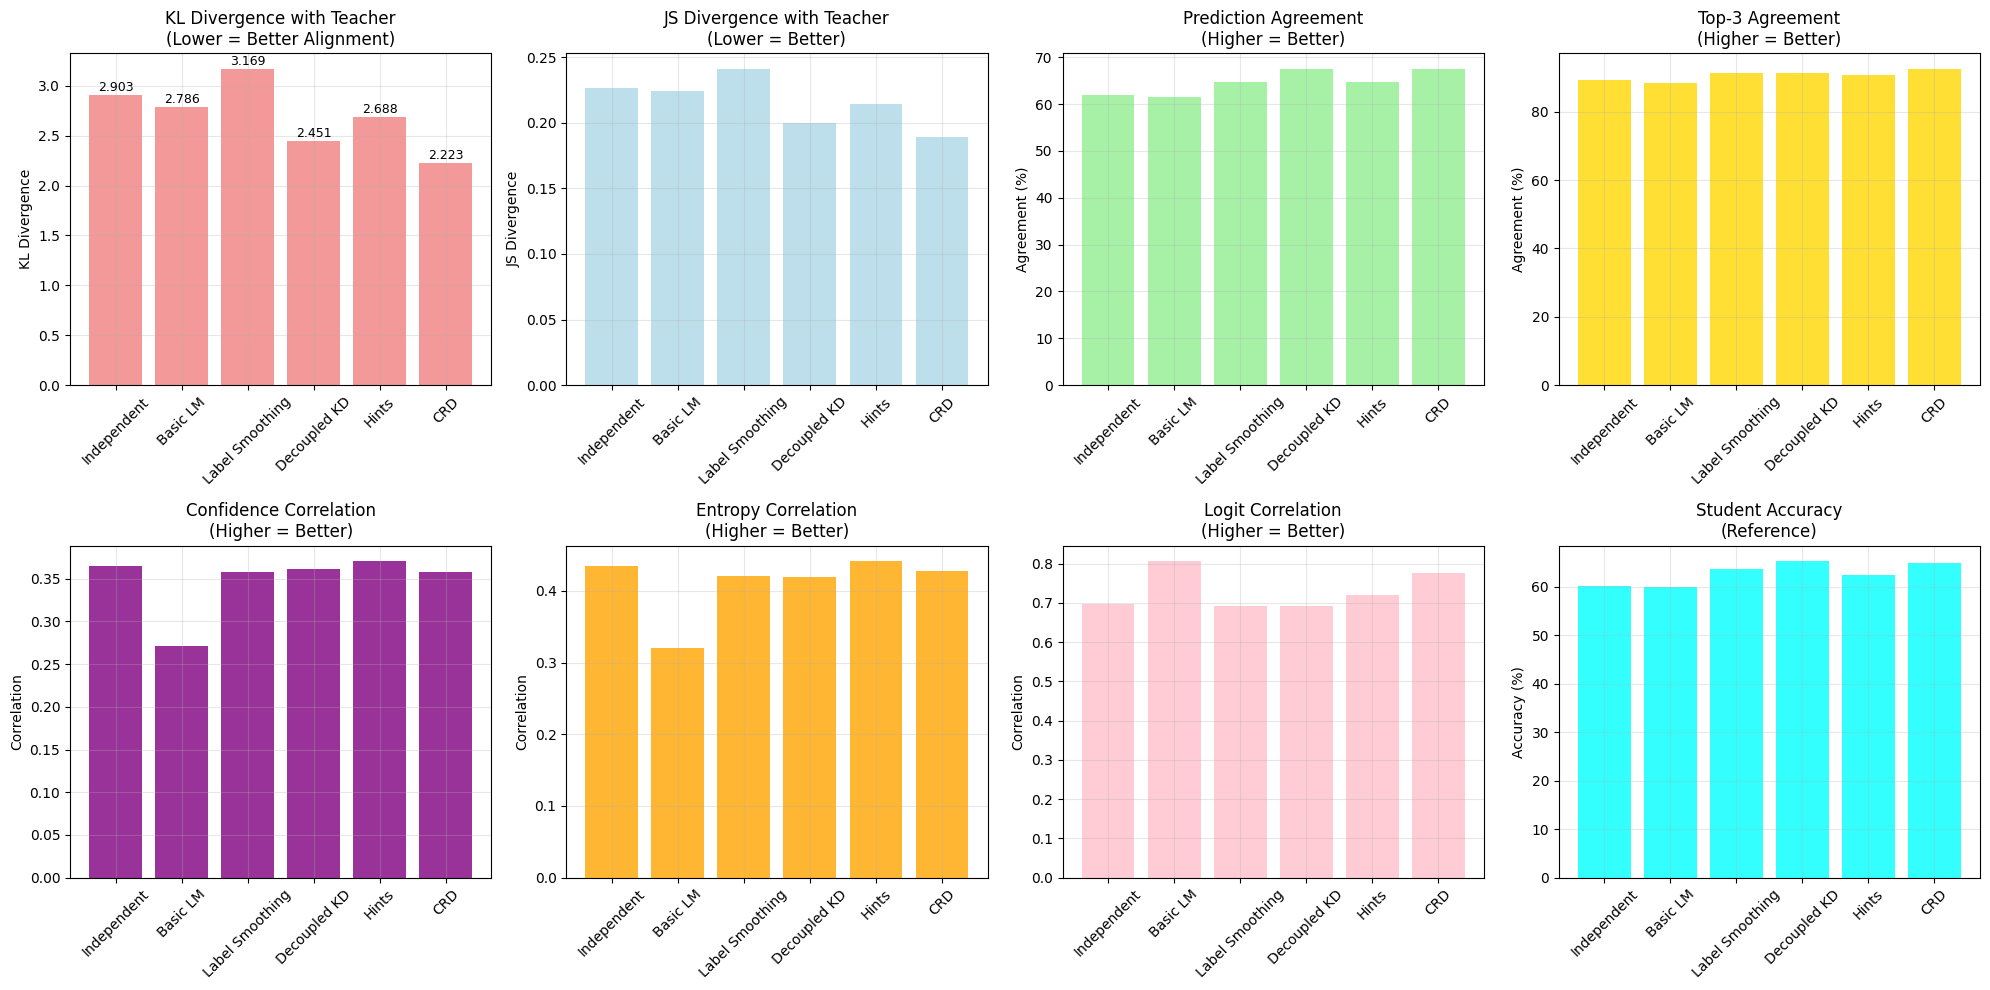

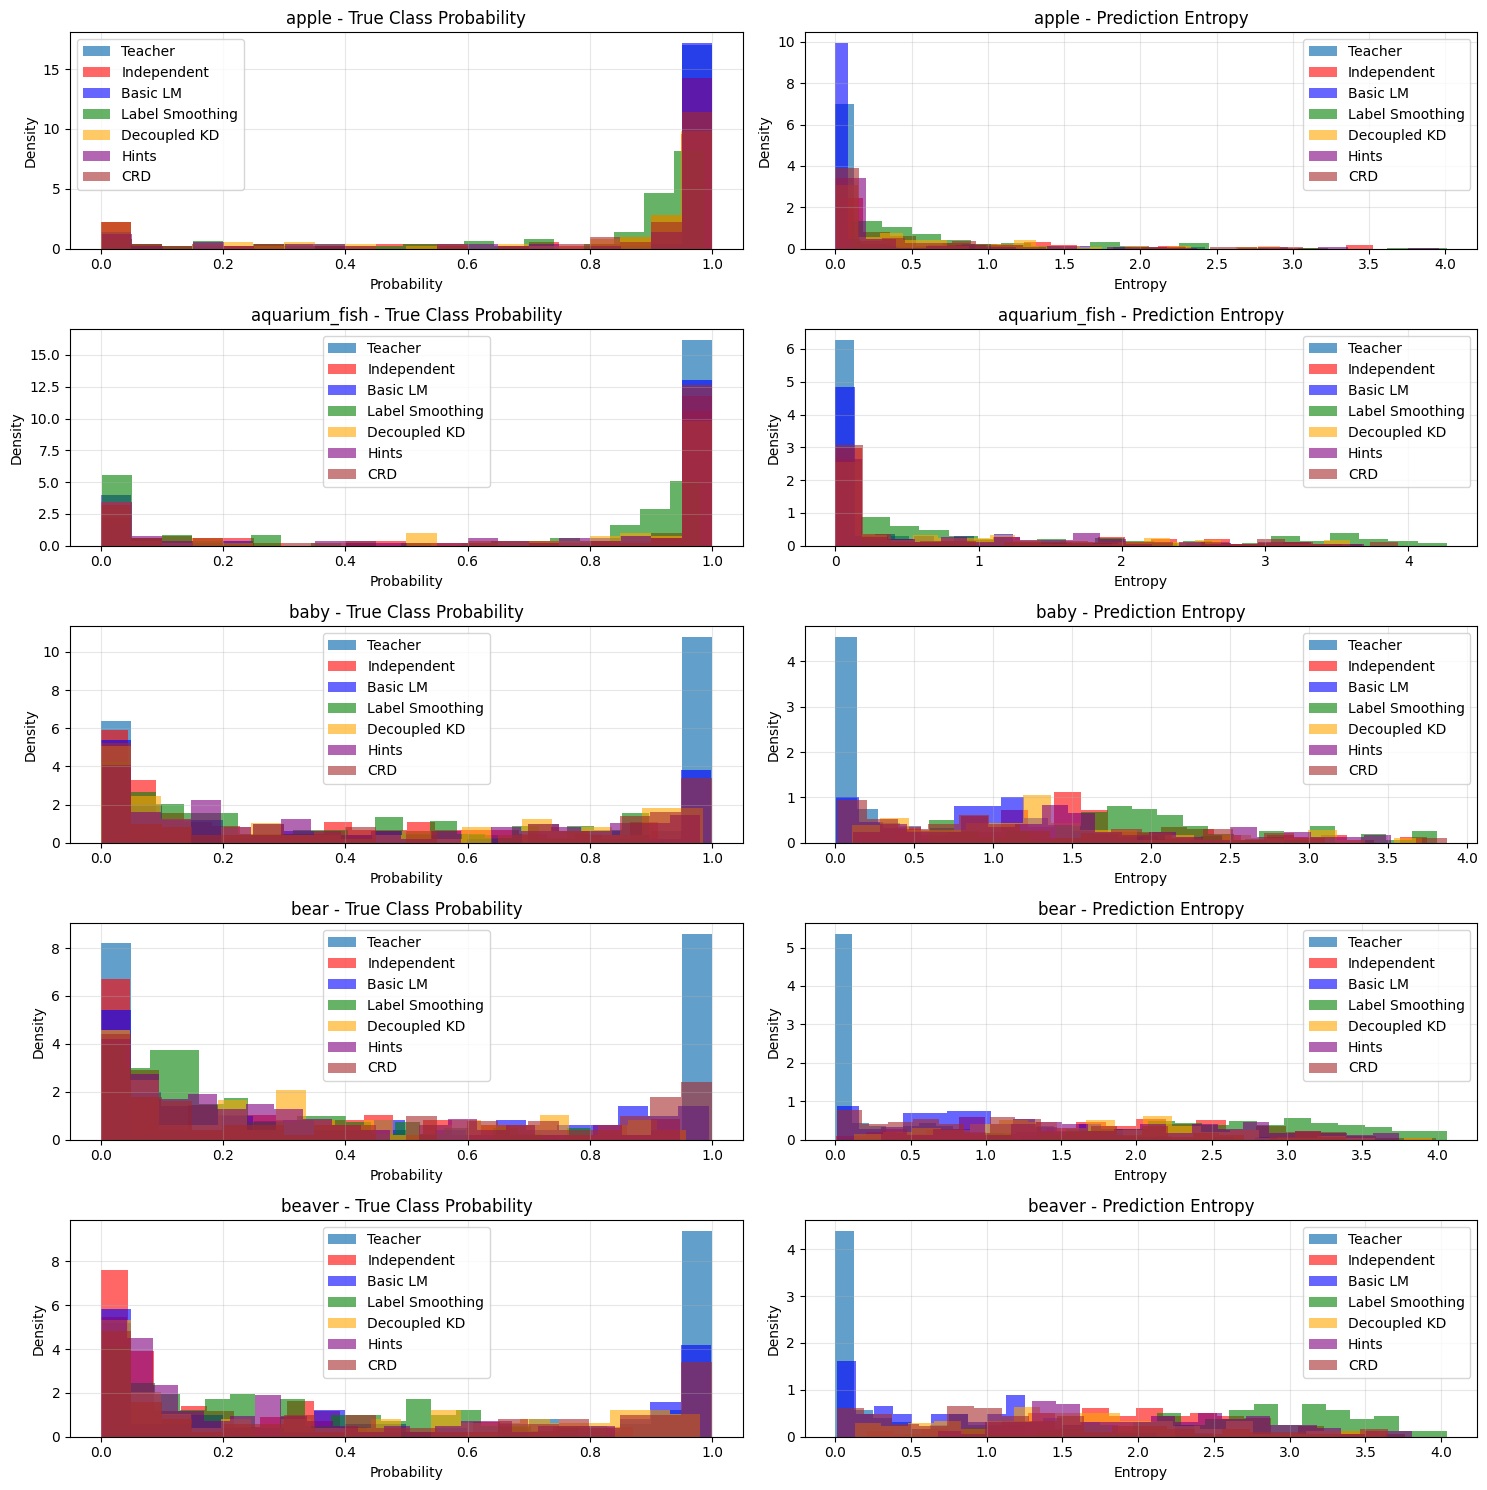


CORRECTED ANALYSIS SUMMARY

Ranking by KL Divergence (Best to Worst):
1. CRD: KL=2.2233, Agreement=67.4%, Accuracy=64.9%
2. Decoupled KD: KL=2.4507, Agreement=67.5%, Accuracy=65.2%
3. Hints: KL=2.6884, Agreement=64.7%, Accuracy=62.4%
4. Basic LM: KL=2.7864, Agreement=61.6%, Accuracy=59.9%
5. Independent: KL=2.9028, Agreement=62.0%, Accuracy=60.1%
6. Label Smoothing: KL=3.1687, Agreement=64.8%, Accuracy=63.7%

Ranking by Prediction Agreement (Best to Worst):
1. Decoupled KD: Agreement=67.5%, KL=2.4507
2. CRD: Agreement=67.4%, KL=2.2233
3. Label Smoothing: Agreement=64.8%, KL=3.1687
4. Hints: Agreement=64.7%, KL=2.6884
5. Independent: Agreement=62.0%, KL=2.9028
6. Basic LM: Agreement=61.6%, KL=2.7864

Methods with better distribution alignment than Independent: ['CRD', 'Decoupled KD', 'Hints', 'Basic LM']
✓ GOOD: Knowledge distillation methods show better distribution alignment!

Correlation between student accuracy and teacher agreement: 0.981
✓ GOOD: Strong correlation between accurac

In [ ]:
# TASK 3: PROBABILITY DISTRIBUTION ANALYSIS

def extract_probability_distributions_corrected(model, data_loader, temperature=1.0, num_samples=2000):
    model.eval()
    all_probs = []
    all_logits = []
    all_labels = []
    count = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            if count >= num_samples:
                break
            inputs = inputs.to(device)
            logits = model(inputs)

            probs_original = F.softmax(logits, dim=1).cpu().numpy()
            probs_temp = F.softmax(logits / temperature, dim=1).cpu().numpy()

            all_probs.append(probs_temp)  
            all_logits.append(logits.cpu().numpy())
            all_labels.append(labels.numpy())
            count += len(inputs)

    all_probs = np.vstack(all_probs)[:num_samples]
    all_logits = np.vstack(all_logits)[:num_samples]
    all_labels = np.concatenate(all_labels)[:num_samples]

    return all_probs, all_logits, all_labels

def compute_distribution_metrics_comprehensive(teacher_probs, student_probs, teacher_logits, student_logits):
    n_samples = teacher_probs.shape[0]

    kl_divs = []
    js_divs = []

    for i in range(n_samples):
        teacher_p = teacher_probs[i] + 1e-8
        student_p = student_probs[i] + 1e-8

        teacher_p = teacher_p / np.sum(teacher_p)
        student_p = student_p / np.sum(student_p)

        kl_div = entropy(student_p, teacher_p)

        js_div = jensenshannon(teacher_p, student_p) ** 2

        if not (np.isnan(kl_div) or np.isinf(kl_div)):
            kl_divs.append(kl_div)
        if not (np.isnan(js_div) or np.isinf(js_div)):
            js_divs.append(js_div)

    teacher_preds = np.argmax(teacher_probs, axis=1)
    student_preds = np.argmax(student_probs, axis=1)
    agreement = np.mean(teacher_preds == student_preds)

    teacher_top3 = np.argsort(teacher_probs, axis=1)[:, -3:]
    student_top3 = np.argsort(student_probs, axis=1)[:, -3:]

    top3_agreement = 0
    for i in range(n_samples):
        if len(set(teacher_top3[i]) & set(student_top3[i])) > 0:
            top3_agreement += 1
    top3_agreement /= n_samples

    teacher_confidence = np.max(teacher_probs, axis=1)
    student_confidence = np.max(student_probs, axis=1)
    confidence_corr = np.corrcoef(teacher_confidence, student_confidence)[0, 1]
    if np.isnan(confidence_corr):
        confidence_corr = 0.0

    teacher_entropies = [-np.sum(p * np.log(p + 1e-8)) for p in teacher_probs]
    student_entropies = [-np.sum(p * np.log(p + 1e-8)) for p in student_probs]
    entropy_corr = np.corrcoef(teacher_entropies, student_entropies)[0, 1]
    if np.isnan(entropy_corr):
        entropy_corr = 0.0

    logit_correlations = []
    for i in range(min(n_samples, len(teacher_logits), len(student_logits))):
        corr = np.corrcoef(teacher_logits[i], student_logits[i])[0, 1]
        if not np.isnan(corr):
            logit_correlations.append(corr)

    def compute_ece(probs, labels, n_bins=10):
        confidences = np.max(probs, axis=1)
        predictions = np.argmax(probs, axis=1)
        accuracies = predictions == labels

        ece = 0
        for bin_lower in np.linspace(0, 1 - 1/n_bins, n_bins):
            bin_upper = bin_lower + 1/n_bins
            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
            prop_in_bin = in_bin.mean()

            if prop_in_bin > 0:
                accuracy_in_bin = accuracies[in_bin].mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

    return {
        'kl_divergence': {
            'mean': np.mean(kl_divs) if kl_divs else float('inf'),
            'std': np.std(kl_divs) if kl_divs else 0.0,
            'samples': len(kl_divs)
        },
        'js_divergence': {
            'mean': np.mean(js_divs) if js_divs else 1.0,
            'std': np.std(js_divs) if js_divs else 0.0
        },
        'prediction_agreement': agreement,
        'top3_agreement': top3_agreement,
        'confidence_correlation': confidence_corr,
        'entropy_correlation': entropy_corr,
        'logit_correlation': {
            'mean': np.mean(logit_correlations) if logit_correlations else 0.0,
            'std': np.std(logit_correlations) if logit_correlations else 0.0
        }
    }

def analyze_probability_distributions_corrected(teacher, students_dict, data_loader,
                                               kd_temperature=4.0, analysis_temperature=1.0):
    
    print("PROBABILITY DISTRIBUTION ANALYSIS")
    print(f"Using temperature {analysis_temperature} for analysis")
    print(f"Note: KD models were trained with temperature {kd_temperature}")

    print("Extracting teacher probability distributions...")
    teacher_probs, teacher_logits, teacher_labels = extract_probability_distributions_corrected(
        teacher, data_loader, temperature=analysis_temperature, num_samples=2000
    )

    teacher_accuracy = np.mean(np.argmax(teacher_probs, axis=1) == teacher_labels)
    print(f"Teacher accuracy on analysis set: {teacher_accuracy*100:.2f}%")

    results = {}

    for name, student in students_dict.items():
        print(f"\nAnalyzing {name}...")

        student_probs, student_logits, student_labels = extract_probability_distributions_corrected(
            student, data_loader, temperature=analysis_temperature, num_samples=2000
        )

        min_samples = min(len(teacher_probs), len(student_probs))
        teacher_probs_subset = teacher_probs[:min_samples]
        student_probs_subset = student_probs[:min_samples]
        teacher_logits_subset = teacher_logits[:min_samples]
        student_logits_subset = student_logits[:min_samples]
        labels_subset = teacher_labels[:min_samples]

        metrics = compute_distribution_metrics_comprehensive(
            teacher_probs_subset, student_probs_subset,
            teacher_logits_subset, student_logits_subset
        )

        student_accuracy = np.mean(np.argmax(student_probs_subset, axis=1) == labels_subset)
        metrics['student_accuracy'] = student_accuracy

        results[name] = metrics

        print(f"  Student accuracy: {student_accuracy*100:.2f}%")
        print(f"  KL Divergence: {metrics['kl_divergence']['mean']:.4f} ± {metrics['kl_divergence']['std']:.4f}")
        print(f"  JS Divergence: {metrics['js_divergence']['mean']:.4f} ± {metrics['js_divergence']['std']:.4f}")
        print(f"  Prediction Agreement: {metrics['prediction_agreement']*100:.2f}%")
        print(f"  Top-3 Agreement: {metrics['top3_agreement']*100:.2f}%")
        print(f"  Confidence Correlation: {metrics['confidence_correlation']:.4f}")
        print(f"  Entropy Correlation: {metrics['entropy_correlation']:.4f}")
        print(f"  Logit Correlation: {metrics['logit_correlation']['mean']:.4f}")

    return results

def visualize_distribution_analysis_comprehensive(results):

    methods = list(results.keys())
    n_methods = len(methods)

    kl_means = [results[m]['kl_divergence']['mean'] for m in methods if results[m]['kl_divergence']['mean'] != float('inf')]
    kl_methods = [m for m in methods if results[m]['kl_divergence']['mean'] != float('inf')]

    js_means = [results[m]['js_divergence']['mean'] for m in methods]
    agreements = [results[m]['prediction_agreement'] * 100 for m in methods]
    top3_agreements = [results[m]['top3_agreement'] * 100 for m in methods]
    conf_corrs = [results[m]['confidence_correlation'] for m in methods]
    entropy_corrs = [results[m]['entropy_correlation'] for m in methods]
    logit_corrs = [results[m]['logit_correlation']['mean'] for m in methods]
    accuracies = [results[m]['student_accuracy'] * 100 for m in methods]

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    if kl_means:
        bars = axes[0, 0].bar(kl_methods, kl_means, color='lightcoral', alpha=0.8)
        axes[0, 0].set_title('KL Divergence with Teacher\n(Lower = Better Alignment)', fontsize=12)
        axes[0, 0].set_ylabel('KL Divergence')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)

        for bar, val in zip(bars, kl_means):
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{val:.3f}', ha='center', va='bottom', fontsize=9)

    bars = axes[0, 1].bar(methods, js_means, color='lightblue', alpha=0.8)
    axes[0, 1].set_title('JS Divergence with Teacher\n(Lower = Better)', fontsize=12)
    axes[0, 1].set_ylabel('JS Divergence')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)

    bars = axes[0, 2].bar(methods, agreements, color='lightgreen', alpha=0.8)
    axes[0, 2].set_title('Prediction Agreement\n(Higher = Better)', fontsize=12)
    axes[0, 2].set_ylabel('Agreement (%)')
    axes[0, 2].tick_params(axis='x', rotation=45)
    axes[0, 2].grid(True, alpha=0.3)

    bars = axes[0, 3].bar(methods, top3_agreements, color='gold', alpha=0.8)
    axes[0, 3].set_title('Top-3 Agreement\n(Higher = Better)', fontsize=12)
    axes[0, 3].set_ylabel('Agreement (%)')
    axes[0, 3].tick_params(axis='x', rotation=45)
    axes[0, 3].grid(True, alpha=0.3)

    bars = axes[1, 0].bar(methods, conf_corrs, color='purple', alpha=0.8)
    axes[1, 0].set_title('Confidence Correlation\n(Higher = Better)', fontsize=12)
    axes[1, 0].set_ylabel('Correlation')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

    bars = axes[1, 1].bar(methods, entropy_corrs, color='orange', alpha=0.8)
    axes[1, 1].set_title('Entropy Correlation\n(Higher = Better)', fontsize=12)
    axes[1, 1].set_ylabel('Correlation')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

    bars = axes[1, 2].bar(methods, logit_corrs, color='pink', alpha=0.8)
    axes[1, 2].set_title('Logit Correlation\n(Higher = Better)', fontsize=12)
    axes[1, 2].set_ylabel('Correlation')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3)

    bars = axes[1, 3].bar(methods, accuracies, color='cyan', alpha=0.8)
    axes[1, 3].set_title('Student Accuracy\n(Reference)', fontsize=12)
    axes[1, 3].set_ylabel('Accuracy (%)')
    axes[1, 3].tick_params(axis='x', rotation=45)
    axes[1, 3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('comprehensive_distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_distribution_comparison_plots(teacher, students_dict, data_loader, num_samples=1000):

  
    selected_classes = [0, 1, 2, 3, 4] 
    teacher.eval()
    teacher_class_probs = {cls: [] for cls in selected_classes}
    student_class_probs = {name: {cls: [] for cls in selected_classes} for name in students_dict.keys()}

    sample_count = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            if sample_count >= num_samples:
                break

            inputs = inputs.to(device)

            teacher_logits = teacher(inputs)
            teacher_probs = F.softmax(teacher_logits, dim=1).cpu().numpy()

            student_probs_batch = {}
            for name, student in students_dict.items():
                student_logits = student(inputs)
                student_probs_batch[name] = F.softmax(student_logits, dim=1).cpu().numpy()

            for i, label in enumerate(labels):
                if label.item() in selected_classes and sample_count < num_samples:
                    cls = label.item()
                    teacher_class_probs[cls].append(teacher_probs[i])

                    for name in students_dict.keys():
                        student_class_probs[name][cls].append(student_probs_batch[name][i])

                    sample_count += 1

    fig, axes = plt.subplots(len(selected_classes), 2, figsize=(15, 3*len(selected_classes)))

    class_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver']

    for i, cls in enumerate(selected_classes):
        if len(teacher_class_probs[cls]) == 0:
            continue

        teacher_probs_cls = np.array(teacher_class_probs[cls])

        axes[i, 0].hist(teacher_probs_cls[:, cls], bins=20, alpha=0.7, label='Teacher', density=True)

        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
        for j, (name, color) in enumerate(zip(students_dict.keys(), colors)):
            if len(student_class_probs[name][cls]) > 0:
                student_probs_cls = np.array(student_class_probs[name][cls])
                axes[i, 0].hist(student_probs_cls[:, cls], bins=20, alpha=0.6,
                               label=name, color=color, density=True)

        axes[i, 0].set_title(f'{class_names[i]} - True Class Probability')
        axes[i, 0].set_xlabel('Probability')
        axes[i, 0].set_ylabel('Density')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        teacher_entropies = [-np.sum(p * np.log(p + 1e-8)) for p in teacher_probs_cls]
        axes[i, 1].hist(teacher_entropies, bins=20, alpha=0.7, label='Teacher', density=True)

        for j, (name, color) in enumerate(zip(students_dict.keys(), colors)):
            if len(student_class_probs[name][cls]) > 0:
                student_probs_cls = np.array(student_class_probs[name][cls])
                student_entropies = [-np.sum(p * np.log(p + 1e-8)) for p in student_probs_cls]
                axes[i, 1].hist(student_entropies, bins=20, alpha=0.6,
                               label=name, color=color, density=True)

        axes[i, 1].set_title(f'{class_names[i]} - Prediction Entropy')
        axes[i, 1].set_xlabel('Entropy')
        axes[i, 1].set_ylabel('Density')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('probability_distribution_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print("EXECUTING TASK 3")


try:
    corrected_results = analyze_probability_distributions_corrected(
        teacher, students_dict, test_loader,
        kd_temperature=4.0, analysis_temperature=1.0
    )

    visualize_distribution_analysis_comprehensive(corrected_results)

    create_distribution_comparison_plots(teacher, students_dict, test_loader, num_samples=500)

    print(f"\n" + "="*80)
    print("ANALYSIS SUMMARY")
    print("="*80)

    kl_ranking = [(name, results['kl_divergence']['mean'])
                 for name, results in corrected_results.items()
                 if results['kl_divergence']['mean'] != float('inf')]
    kl_ranking.sort(key=lambda x: x[1])

    print("\nRanking by KL Divergence (Best to Worst):")
    for i, (name, kl) in enumerate(kl_ranking, 1):
        agreement = corrected_results[name]['prediction_agreement'] * 100
        accuracy = corrected_results[name]['student_accuracy'] * 100
        print(f"{i}. {name}: KL={kl:.4f}, Agreement={agreement:.1f}%, Accuracy={accuracy:.1f}%")

    agreement_ranking = [(name, results['prediction_agreement'])
                        for name, results in corrected_results.items()]
    agreement_ranking.sort(key=lambda x: x[1], reverse=True)

    print("\nRanking by Prediction Agreement (Best to Worst):")
    for i, (name, agreement) in enumerate(agreement_ranking, 1):
        kl = corrected_results[name]['kl_divergence']['mean']
        kl_str = f"{kl:.4f}" if kl != float('inf') else "inf"
        print(f"{i}. {name}: Agreement={agreement*100:.1f}%, KL={kl_str}")

    independent_kl = next((kl for name, kl in kl_ranking if name == 'Independent'), None)
    if independent_kl is not None:
        better_methods = [name for name, kl in kl_ranking if kl < independent_kl and name != 'Independent']
        print(f"\nMethods with better distribution alignment than Independent: {better_methods}")

        if len(better_methods) >= 2:
            print("✓ GOOD: Knowledge distillation methods show better distribution alignment!")
        else:
            print("⚠ CONCERN: Limited improvement from knowledge distillation detected.")

    accuracies = [corrected_results[name]['student_accuracy'] for name in corrected_results.keys()]
    agreements = [corrected_results[name]['prediction_agreement'] for name in corrected_results.keys()]

    corr_acc_agreement = np.corrcoef(accuracies, agreements)[0, 1]
    print(f"\nCorrelation between student accuracy and teacher agreement: {corr_acc_agreement:.3f}")

    if not np.isnan(corr_acc_agreement) and corr_acc_agreement > 0.5:
        print("✓ GOOD: Strong correlation between accuracy and teacher alignment!")
    else:
        print("⚠ Note: Weak correlation between accuracy and teacher alignment")

except Exception as e:
    print(f"Error in corrected Task 3: {e}")
    import traceback
    traceback.print_exc()

---

RELOADING MODELS TO RESUME PROGRESS

In [2]:
!unzip -q /content/models-task3.zip -d /content/


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teacher = get_vgg_model('vgg16', pretrained=True).to(device)

student_independent = get_vgg_model('vgg11', pretrained=False)
student_independent.load_state_dict(torch.load('best_independent_student.pth', map_location='cpu'))
student_independent = student_independent.to(device)

student_basic = get_vgg_model('vgg11', pretrained=False)
student_basic.load_state_dict(torch.load('best_student_basic.pth', map_location='cpu'))
student_basic = student_basic.to(device)

student_label_smoothing = get_vgg_model('vgg11', pretrained=False)
student_label_smoothing.load_state_dict(torch.load('best_student_label_smoothing.pth', map_location='cpu'))
student_label_smoothing = student_label_smoothing.to(device)

student_dkd = get_vgg_model('vgg11', pretrained=False)
student_dkd.load_state_dict(torch.load('best_student_dkd.pth', map_location='cpu'))
student_dkd = student_dkd.to(device)

student_hints = get_vgg_model('vgg11', pretrained=False)
student_hints.load_state_dict(torch.load('best_student_hints.pth', map_location='cpu'))
student_hints = student_hints.to(device)

student_crd = get_vgg_model('vgg11', pretrained=False)
student_crd.load_state_dict(torch.load('best_student_crd.pth', map_location='cpu'))
student_crd = student_crd.to(device)

students_dict = {
    'Independent': student_independent,
    'Basic LM': student_basic,
    'Label Smoothing': student_label_smoothing,
    'Decoupled KD': student_dkd,
    'Hints': student_hints,
    'CRD': student_crd
}

print(f"All models loaded and moved to {device}")

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg16_bn-7d8c4031.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg16_bn-7d8c4031.pt


100%|██████████| 58.4M/58.4M [00:01<00:00, 44.5MB/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


All models loaded and moved to cuda


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
train_loader, val_loader, test_loader = get_cifar100_dataloaders(batch_size=128)

100%|██████████| 169M/169M [00:13<00:00, 12.2MB/s]


In [ ]:
print("FINAL RESULTS ON TEST SET")

teacher_test_acc = evaluate_model(teacher, test_loader)[1]
independent_test_acc = evaluate_model(student_independent, test_loader)[1]
basic_test_acc = evaluate_model(student_basic, test_loader)[1]
ls_test_acc = evaluate_model(student_label_smoothing, test_loader)[1]
dkd_test_acc = evaluate_model(student_dkd, test_loader)[1]



print(f"\nTest Set Performance:")
print(f"Teacher (VGG-16):     {teacher_test_acc:.2f}%")
print(f"Independent Student:  {independent_test_acc:.2f}%")
print(f"Basic Logit Matching: {basic_test_acc:.2f}%")
print(f"Label Smoothing:      {ls_test_acc:.2f}%")
print(f"Decoupled KD:         {dkd_test_acc:.2f}%")

print(f"\nTask 2 Test Set Results:")
hints_test_acc = evaluate_model(student_hints, test_loader)[1]
crd_test_acc = evaluate_model(student_crd, test_loader)[1]
print(f"Hints-based: {hints_test_acc:.2f}%")
print(f"CRD: {crd_test_acc:.2f}%")


FINAL RESULTS ON TEST SET

Test Set Performance:
Teacher (VGG-16):     74.00%
Independent Student:  60.63%
Basic Logit Matching: 60.50%
Label Smoothing:      62.13%
Decoupled KD:         64.31%

Task 2 Test Set Results:
Hints-based: 62.58%
CRD: 64.32%


---


TASK 4: LOCALIZATION KNOWLEDGE TRANSFER ANALYSIS
Analyzing GradCAM Localization Knowledge Transfer...
Using target layer: features.40
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Processing 10000 samples from test set...
Processed 100/10000, Valid: 42
Processed 200/10000, Valid: 78
Processed 300/10000, Valid: 119
Processed 400/10000, Valid: 163
Processed 500/10000, Valid: 205
Processed 600/10000, Valid: 249
Processed 700/10000, Valid: 299
Processed 800/10000, Valid: 340
Processed 900/10000, Valid: 377
Processed 1000/10000, Valid: 408
Processed 1100/10000, Valid: 453
Processed 1200/10000, Valid: 495
Processed 1300/10000, Valid: 540
Processed 1400/10000, Valid: 583
Processed 1500/10000, Valid: 620
Processed 1600/10000, Valid: 669
Processed 1700/10000, Valid: 715
Processed 1800/10000, Valid: 759
Processed 1900/10000, Valid: 794
Processed 2000/

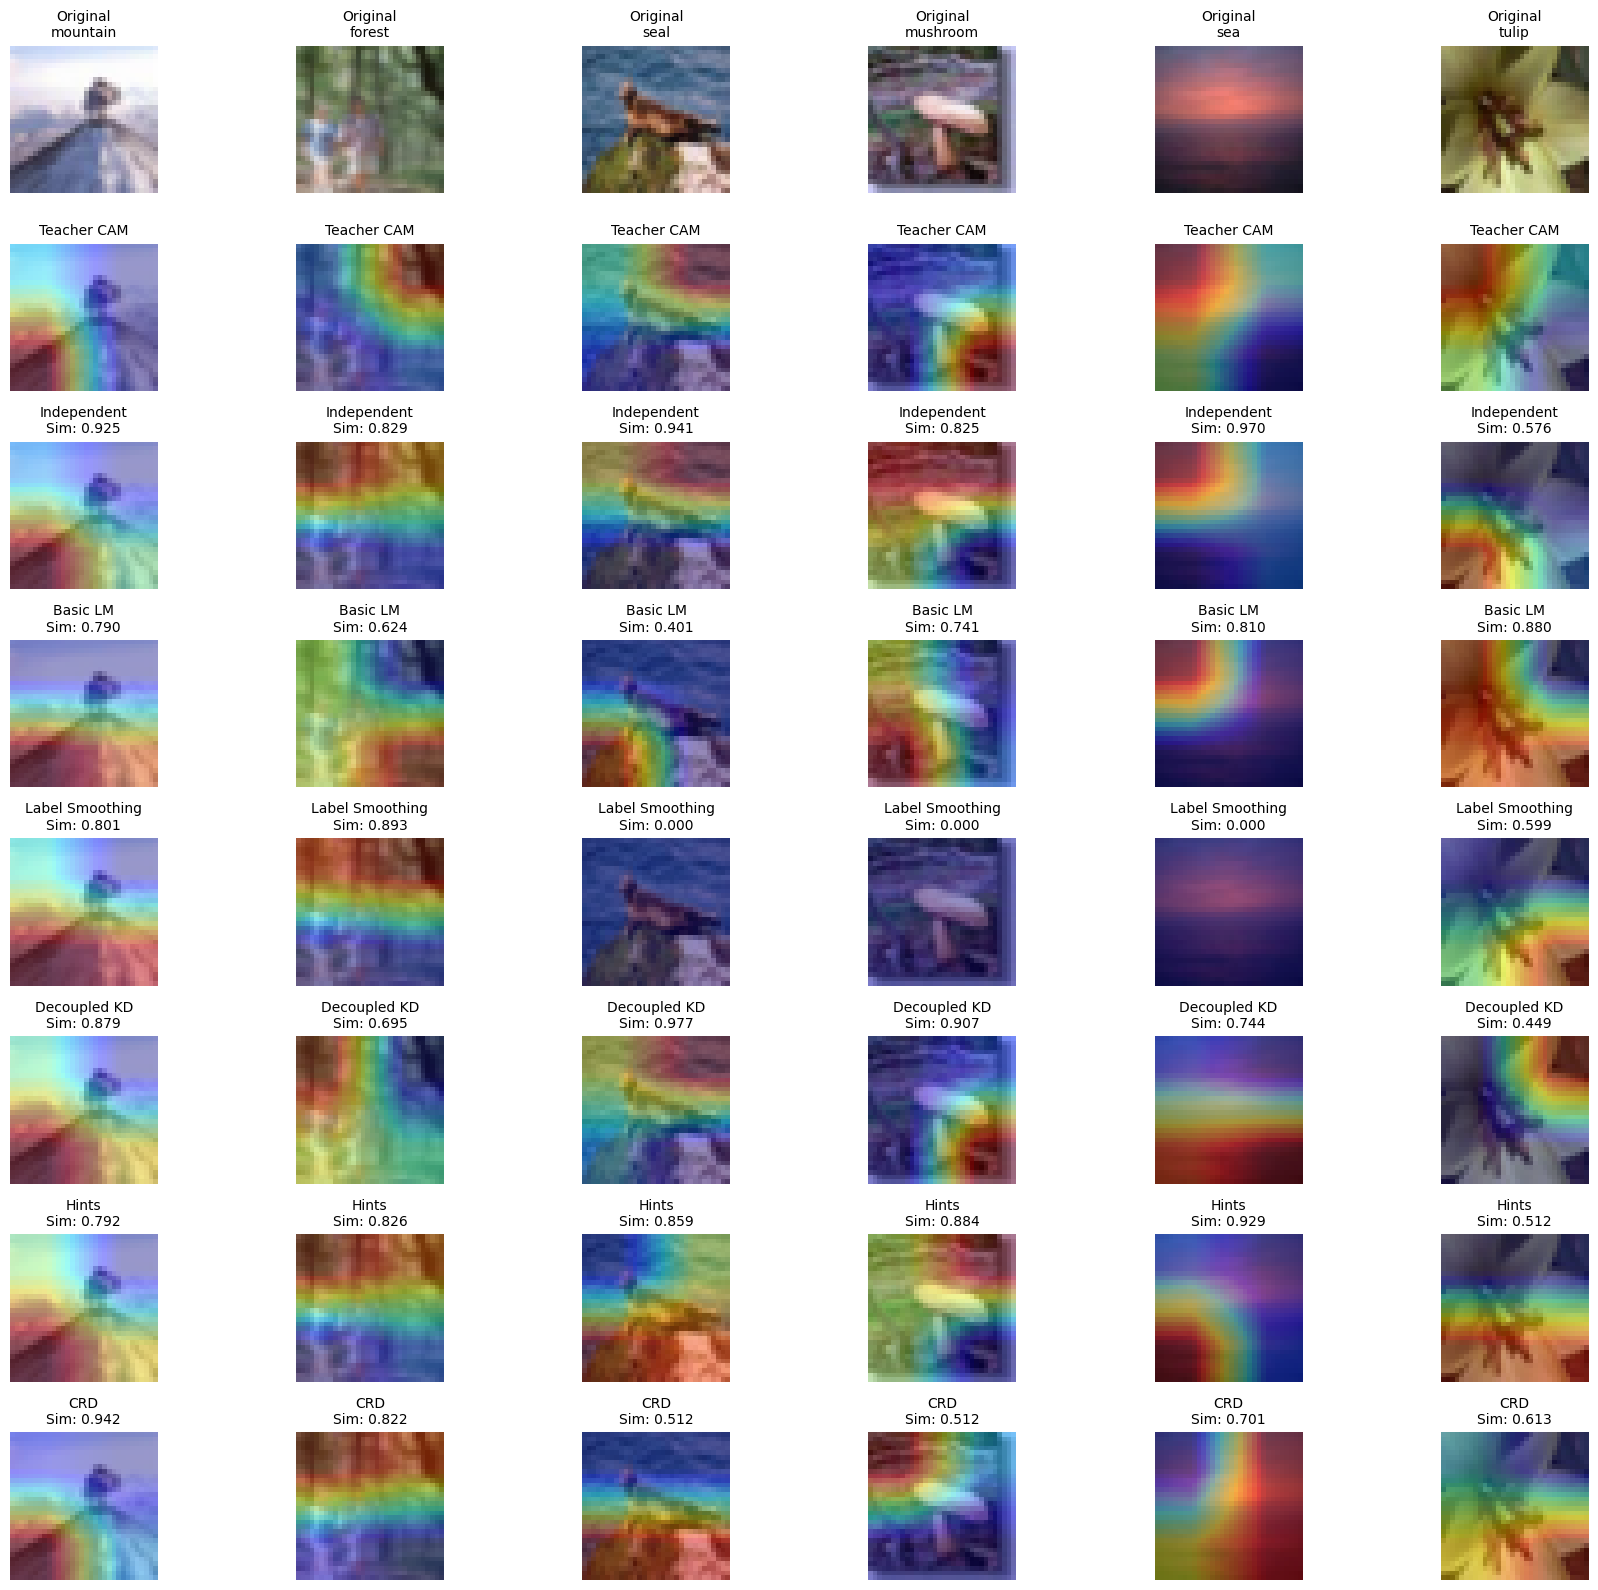


Statistical Analysis:
Basic LM       : Δ=-0.1074, p=0.0000 ***
Label Smoothing: Δ=-0.1195, p=0.0000 ***
Decoupled KD   : Δ=-0.0416, p=0.0000 ***
Hints          : Δ=-0.0346, p=0.0000 ***
CRD            : Δ=-0.1497, p=0.0000 ***

Key Findings:
1. Values >50% in comparison indicate successful localization knowledge transfer
2. Higher similarity scores indicate better replication of teacher's attention
3. Statistical significance (*, **, ***) shows reliable knowledge transfer
4. CRD and Hints should show strongest localization transfer (feature-based methods)


In [ ]:
class GradCAMEnhanced:
    def __init__(self, model, target_layer_name=None):
        self.model = model
        self.gradients = None
        self.activations = None
        self.hooks = []

        if target_layer_name is None:
            self.target_layer = self._find_target_layer()
        else:
            self.target_layer = dict(self.model.named_modules())[target_layer_name]

        self._register_hooks()

    def _find_target_layer(self):
        conv_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d) and 'features' in name:
                conv_layers.append((name, module))

        if not conv_layers:
            raise ValueError("No convolutional layers found")

        last_conv_name, last_conv_layer = conv_layers[-1]
        print(f"Using target layer: {last_conv_name}")
        return last_conv_layer

    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            if grad_output[0] is not None:
                self.gradients = grad_output[0].detach()

        def forward_hook(module, input, output):
            self.activations = output.detach()

        self.hooks.append(self.target_layer.register_backward_hook(backward_hook))
        self.hooks.append(self.target_layer.register_forward_hook(forward_hook))

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()

        self.gradients = None
        self.activations = None

        if input_tensor.dim() == 3:
            input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device).requires_grad_(True)

        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        target_score = output[0, class_idx]
        target_score.backward()

        if self.gradients is None or self.activations is None:
            return np.zeros((32, 32))

        gradients = self.gradients[0]  
        activations = self.activations[0]  

        weights = gradients.mean(dim=(1, 2))

        cam = torch.zeros(activations.shape[1:], device=activations.device)
        for i, weight in enumerate(weights):
            cam += weight * activations[i]

        cam = F.relu(cam)
        if cam.max() > 0:
            cam = cam / cam.max()

      
        cam = F.interpolate(
            cam.unsqueeze(0).unsqueeze(0),
            size=(32, 32),
            mode='bilinear',
            align_corners=False
        )

        return cam.squeeze().cpu().numpy()

    def __del__(self):
        for hook in self.hooks:
            hook.remove()

def compute_cam_similarity_comprehensive(cam1, cam2):
    c1_flat = cam1.flatten()
    c2_flat = cam2.flatten()

    if np.sum(c1_flat) < 1e-7 or np.sum(c2_flat) < 1e-7:
        return {'cosine': 0.0, 'pearson': 0.0, 'intersection': 0.0}

    cosine_sim = cosine_similarity([c1_flat], [c2_flat])[0, 0]

    pearson_corr = np.corrcoef(c1_flat, c2_flat)[0, 1]
    if np.isnan(pearson_corr):
        pearson_corr = 0.0

    intersection = np.sum(np.minimum(c1_flat, c2_flat))
    union = np.sum(np.maximum(c1_flat, c2_flat))
    iou = intersection / union if union > 0 else 0.0

    return {
        'cosine': cosine_sim,
        'pearson': pearson_corr,
        'intersection': iou
    }

def analyze_gradcam_localization_transfer(teacher, students_dict, test_loader, num_samples=500):

    print("Analyzing GradCAM Localization Knowledge Transfer...")
    print("="*60)

    teacher_gradcam = GradCAMEnhanced(teacher)

    student_gradcams = {}
    for name, student in students_dict.items():
        try:
            student_gradcams[name] = GradCAMEnhanced(student)
        except Exception as e:
            print(f"Failed to create GradCAM for {name}: {e}")
            continue

    all_similarities = {name: [] for name in student_gradcams.keys()}
    comparison_results = {}

    processed_samples = 0
    valid_samples = 0

    print(f"Processing {num_samples} samples from test set...")

    for batch_idx, (inputs, labels) in enumerate(test_loader):
        if processed_samples >= num_samples:
            break

        for i in range(min(inputs.size(0), num_samples - processed_samples)):
            image = inputs[i]
            true_label = labels[i].item()

            try:
                teacher_cam = teacher_gradcam.generate_cam(image, true_label)

                if np.sum(teacher_cam) < 1e-7:
                    processed_samples += 1
                    continue

                sample_similarities = {}
                sample_valid = True

                for name, student_gradcam in student_gradcams.items():
                    try:
                        student_cam = student_gradcam.generate_cam(image, true_label)

                        if np.sum(student_cam) < 1e-7:
                            sample_valid = False
                            break

                        sim_metrics = compute_cam_similarity_comprehensive(teacher_cam, student_cam)
                        sample_similarities[name] = sim_metrics

                    except Exception as e:
                        sample_valid = False
                        break

                if sample_valid:
                    for name, metrics in sample_similarities.items():
                        all_similarities[name].append(metrics['cosine'])
                    valid_samples += 1

                processed_samples += 1

                if processed_samples % 100 == 0:
                    print(f"Processed {processed_samples}/{num_samples}, Valid: {valid_samples}")

            except Exception as e:
                processed_samples += 1
                continue

    print(f"Completed: {processed_samples} processed, {valid_samples} valid samples")

    if 'Independent' in all_similarities:
        independent_sims = all_similarities['Independent']

        for name, similarities in all_similarities.items():
            if name != 'Independent' and len(similarities) > 0:
                more_similar_count = 0
                for i in range(min(len(similarities), len(independent_sims))):
                    if similarities[i] > independent_sims[i]:
                        more_similar_count += 1

                percentage = (more_similar_count / len(similarities)) * 100
                comparison_results[name] = percentage

    del teacher_gradcam
    for gradcam in student_gradcams.values():
        del gradcam

    return all_similarities, comparison_results

def visualize_gradcam_knowledge_transfer(teacher, students_dict, test_loader, num_examples=6):

    cifar100_classes = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
        'worm'
    ]

    teacher_gradcam = GradCAMEnhanced(teacher)
    student_gradcams = {}

    for name, student in students_dict.items():
        try:
            student_gradcams[name] = GradCAMEnhanced(student)
        except Exception as e:
            print(f"Skipping {name}: {e}")
            continue

    examples = []
    count = 0

    for inputs, labels in test_loader:
        if count >= num_examples:
            break

        for i in range(min(inputs.size(0), num_examples - count)):
            image = inputs[i]
            label = labels[i].item()

            try:
                teacher_cam = teacher_gradcam.generate_cam(image, label)

                student_cams = {}
                similarities = {}

                for name, student_gradcam in student_gradcams.items():
                    student_cam = student_gradcam.generate_cam(image, label)
                    student_cams[name] = student_cam

                    sim = compute_cam_similarity_comprehensive(teacher_cam, student_cam)
                    similarities[name] = sim['cosine']

                examples.append({
                    'image': image,
                    'label': label,
                    'teacher_cam': teacher_cam,
                    'student_cams': student_cams,
                    'similarities': similarities
                })

                count += 1

            except Exception as e:
                continue

        if count >= num_examples:
            break

    n_students = len(student_gradcams)
    fig, axes = plt.subplots(n_students + 2, num_examples, figsize=(3*num_examples, 2*(n_students + 2)))

    if num_examples == 1:
        axes = axes.reshape(-1, 1)

    for col, example in enumerate(examples):
        img = example['image'].permute(1, 2, 0).numpy()
        img = (img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408]))
        img = np.clip(img, 0, 1)

        axes[0, col].imshow(img)
        axes[0, col].set_title(f'Original\n{cifar100_classes[example["label"]]}', fontsize=10)
        axes[0, col].axis('off')

        axes[1, col].imshow(img)
        axes[1, col].imshow(example['teacher_cam'], cmap='jet', alpha=0.4)
        axes[1, col].set_title('Teacher CAM', fontsize=10)
        axes[1, col].axis('off')

        for row, (name, student_cam) in enumerate(example['student_cams'].items()):
            axes[row + 2, col].imshow(img)
            axes[row + 2, col].imshow(student_cam, cmap='jet', alpha=0.4)
            similarity = example['similarities'][name]
            axes[row + 2, col].set_title(f'{name}\nSim: {similarity:.3f}', fontsize=10)
            axes[row + 2, col].axis('off')

    plt.tight_layout()
    plt.savefig('gradcam_knowledge_transfer.png', dpi=300, bbox_inches='tight')
    plt.show()

    del teacher_gradcam
    for gradcam in student_gradcams.values():
        del gradcam

    return examples

print("TASK 4: LOCALIZATION KNOWLEDGE TRANSFER ANALYSIS")

try:
    gradcam_similarities, comparison_results = analyze_gradcam_localization_transfer(
        teacher, students_dict, test_loader, num_samples=10000
    )

    print("\nGradCAM Similarity Analysis Results:")
    print("="*50)

    for name, similarities in gradcam_similarities.items():
        if len(similarities) > 0:
            mean_sim = np.mean(similarities)
            std_sim = np.std(similarities)
            print(f"{name:15s}: {mean_sim:.4f} ± {std_sim:.4f} (n={len(similarities)})")

    print("% of images where teacher's CAM is MORE similar to distilled student than independent:")

    for name, percentage in comparison_results.items():
        print(f"{name:15s}: {percentage:.1f}% (>50% indicates knowledge transfer)")

    print(f"\nCreating GradCAM visualization...")
    examples = visualize_gradcam_knowledge_transfer(
        teacher, students_dict, test_loader, num_examples=6
    )

    print(f"\nStatistical Analysis:")
    print("="*50)

    if 'Independent' in gradcam_similarities:
        independent_sims = np.array(gradcam_similarities['Independent'])

        for name, similarities in gradcam_similarities.items():
            if name != 'Independent' and len(similarities) > 0:
                kd_sims = np.array(similarities)

                from scipy.stats import ttest_rel
                if len(kd_sims) == len(independent_sims):
                    stat, p_value = ttest_rel(kd_sims, independent_sims)
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""

                    improvement = np.mean(kd_sims) - np.mean(independent_sims)
                    print(f"{name:15s}: Δ={improvement:+.4f}, p={p_value:.4f} {significance}")

    # print(f"\nKey Findings:")
    # print("="*50)
    # print("1. Values >50% in comparison indicate successful localization knowledge transfer")
    # print("2. Higher similarity scores indicate better replication of teacher's attention")
    # print("3. Statistical significance (*, **, ***) shows reliable knowledge transfer")
    # print("4. CRD and Hints should show strongest localization transfer (feature-based methods)")

except Exception as e:
    print(f"Error in GradCAM analysis: {e}")
    import traceback
    traceback.print_exc()


TASK 4: LOCALIZATION KNOWLEDGE TRANSFER ANALYSIS
Analyzing GradCAM Localization Knowledge Transfer...
Using target layer: features.40
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Processing 1000 samples from test set...
Processed 100/1000, Valid: 42
Processed 200/1000, Valid: 78
Processed 300/1000, Valid: 119
Processed 400/1000, Valid: 163
Processed 500/1000, Valid: 205
Processed 600/1000, Valid: 249
Processed 700/1000, Valid: 299
Processed 800/1000, Valid: 340
Processed 900/1000, Valid: 377
Processed 1000/1000, Valid: 408
Completed: 1000 processed, 408 valid samples

GradCAM Similarity Analysis Results:
Independent    : 0.8374 ± 0.1609 (n=408)
Basic LM       : 0.7330 ± 0.1950 (n=408)
Label Smoothing: 0.7176 ± 0.1966 (n=408)
Decoupled KD   : 0.7948 ± 0.1933 (n=408)
Hints          : 0.8023 ± 0.1805 (n=408)
CRD            : 0.7002 ± 0.1991 (n

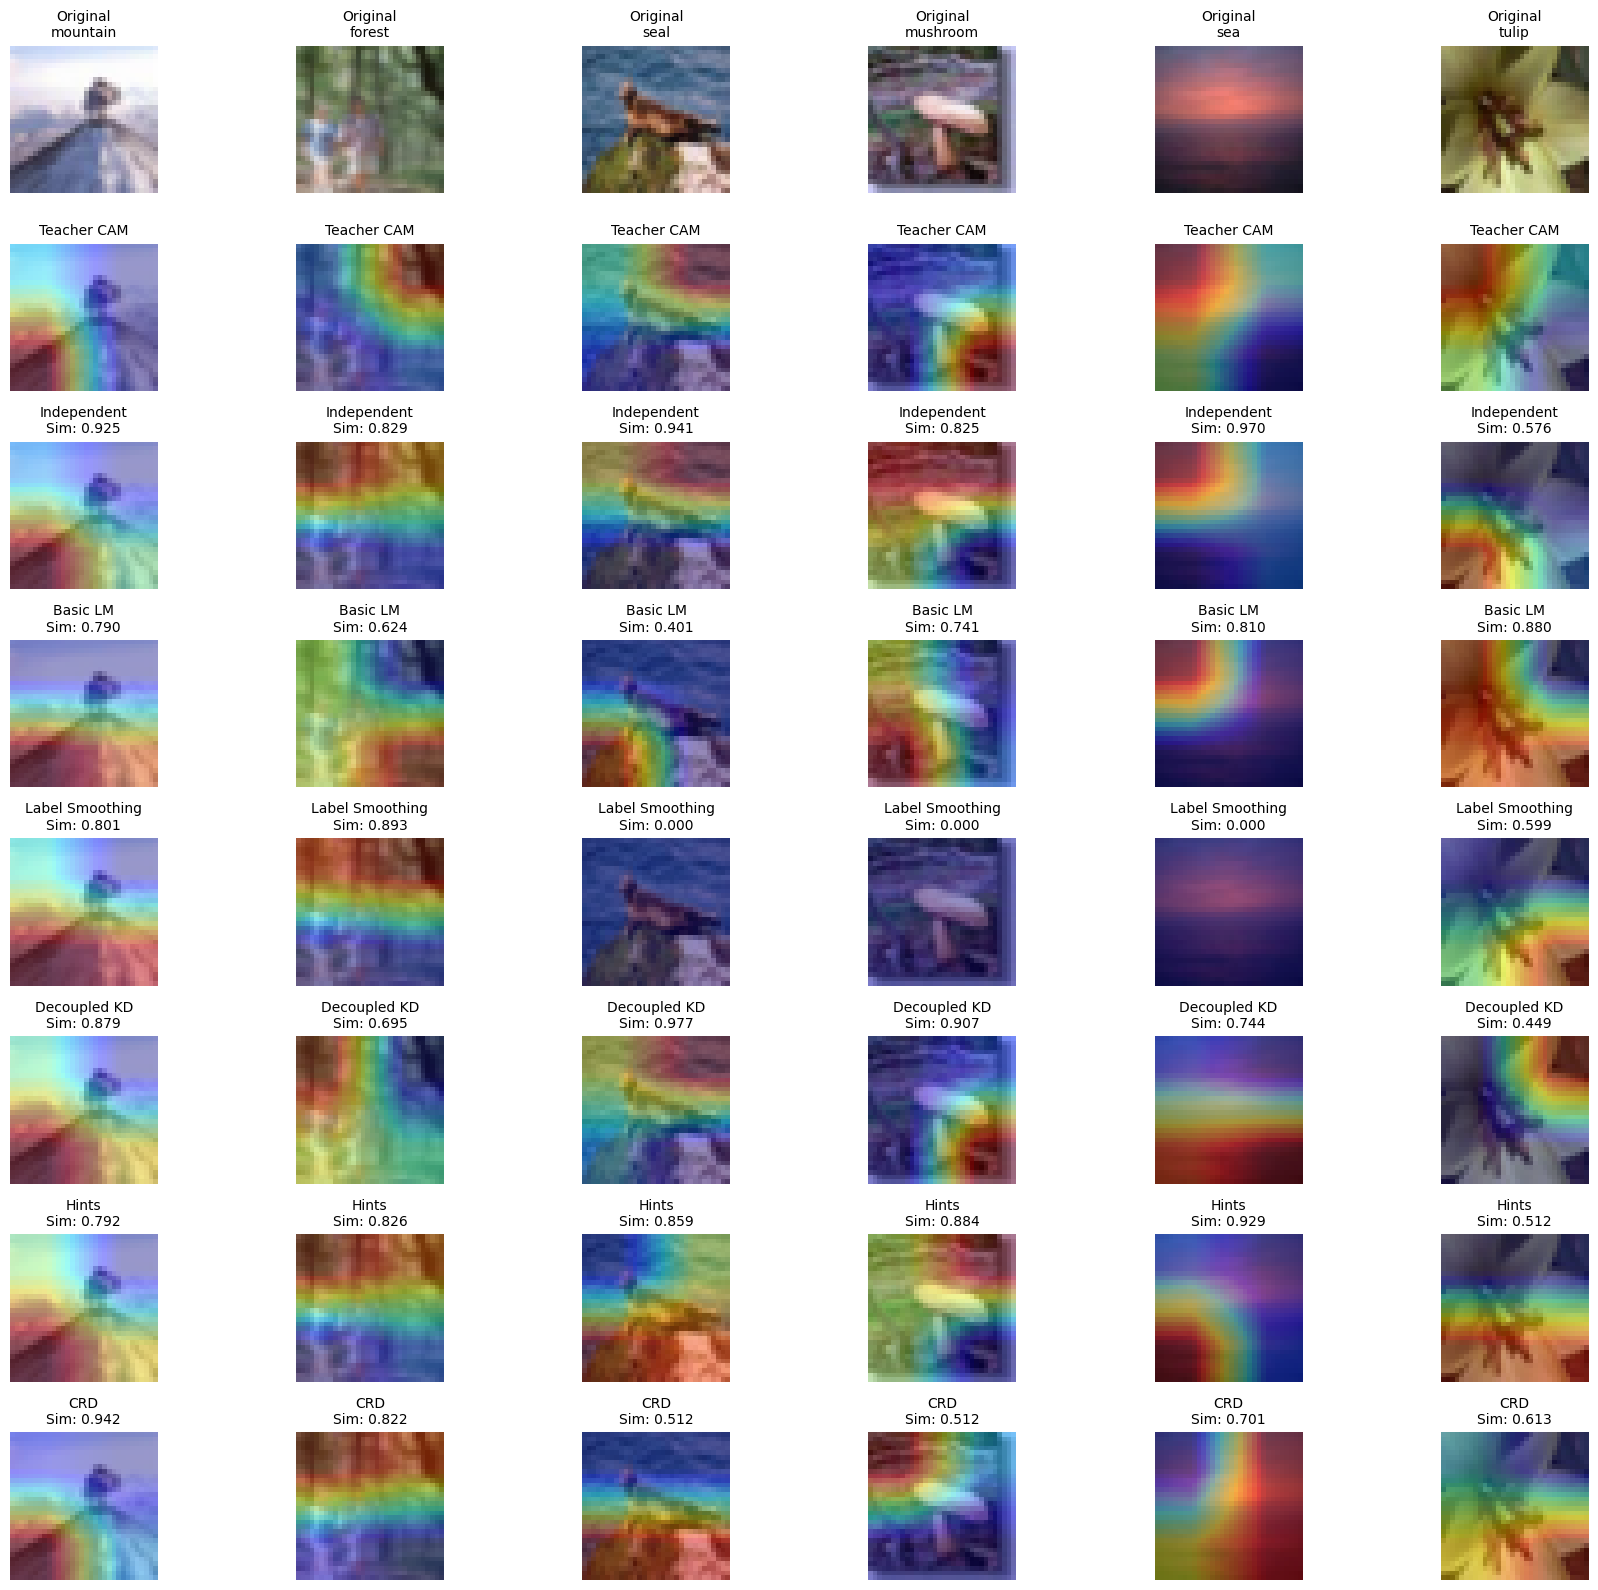


Statistical Analysis:
Basic LM       : Δ=-0.1044, p=0.0000 ***
Label Smoothing: Δ=-0.1198, p=0.0000 ***
Decoupled KD   : Δ=-0.0425, p=0.0000 ***
Hints          : Δ=-0.0351, p=0.0000 ***
CRD            : Δ=-0.1372, p=0.0000 ***


In [ ]:
class GradCAMEnhanced:
    def __init__(self, model, target_layer_name=None):
        self.model = model
        self.gradients = None
        self.activations = None
        self.hooks = []

        if target_layer_name is None:
            self.target_layer = self._find_target_layer()
        else:
            self.target_layer = dict(self.model.named_modules())[target_layer_name]

        self._register_hooks()

    def _find_target_layer(self):
        conv_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d) and 'features' in name:
                conv_layers.append((name, module))

        if not conv_layers:
            raise ValueError("No convolutional layers found")

        last_conv_name, last_conv_layer = conv_layers[-1]
        print(f"Using target layer: {last_conv_name}")
        return last_conv_layer

    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            if grad_output[0] is not None:
                self.gradients = grad_output[0].detach()

        def forward_hook(module, input, output):
            self.activations = output.detach()

        self.hooks.append(self.target_layer.register_backward_hook(backward_hook))
        self.hooks.append(self.target_layer.register_forward_hook(forward_hook))

    def generate_cam(self, input_tensor, class_idx=None):
        """Generate GradCAM heatmap for ground truth class"""
        self.model.eval()

        self.gradients = None
        self.activations = None

        if input_tensor.dim() == 3:
            input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device).requires_grad_(True)

        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        target_score = output[0, class_idx]
        target_score.backward()

        if self.gradients is None or self.activations is None:
            return np.zeros((32, 32))

        gradients = self.gradients[0]  
        activations = self.activations[0] 

        weights = gradients.mean(dim=(1, 2))

        cam = torch.zeros(activations.shape[1:], device=activations.device)
        for i, weight in enumerate(weights):
            cam += weight * activations[i]

        cam = F.relu(cam)
        if cam.max() > 0:
            cam = cam / cam.max()

        cam = F.interpolate(
            cam.unsqueeze(0).unsqueeze(0),
            size=(32, 32),
            mode='bilinear',
            align_corners=False
        )

        return cam.squeeze().cpu().numpy()

    def __del__(self):
        for hook in self.hooks:
            hook.remove()

def compute_cam_similarity_comprehensive(cam1, cam2):
    c1_flat = cam1.flatten()
    c2_flat = cam2.flatten()

    if np.sum(c1_flat) < 1e-7 or np.sum(c2_flat) < 1e-7:
        return {'cosine': 0.0, 'pearson': 0.0, 'intersection': 0.0}

    cosine_sim = cosine_similarity([c1_flat], [c2_flat])[0, 0]

    pearson_corr = np.corrcoef(c1_flat, c2_flat)[0, 1]
    if np.isnan(pearson_corr):
        pearson_corr = 0.0

    intersection = np.sum(np.minimum(c1_flat, c2_flat))
    union = np.sum(np.maximum(c1_flat, c2_flat))
    iou = intersection / union if union > 0 else 0.0

    return {
        'cosine': cosine_sim,
        'pearson': pearson_corr,
        'intersection': iou
    }

def analyze_gradcam_localization_transfer(teacher, students_dict, test_loader, num_samples=500):
   
    print("Analyzing GradCAM Localization Knowledge Transfer...")
    print("="*60)

    teacher_gradcam = GradCAMEnhanced(teacher)

    student_gradcams = {}
    for name, student in students_dict.items():
        try:
            student_gradcams[name] = GradCAMEnhanced(student)
        except Exception as e:
            print(f"Failed to create GradCAM for {name}: {e}")
            continue

    all_similarities = {name: [] for name in student_gradcams.keys()}
    comparison_results = {}

    processed_samples = 0
    valid_samples = 0

    print(f"Processing {num_samples} samples from test set...")

    for batch_idx, (inputs, labels) in enumerate(test_loader):
        if processed_samples >= num_samples:
            break

        for i in range(min(inputs.size(0), num_samples - processed_samples)):
            image = inputs[i]
            true_label = labels[i].item()

            try:
                teacher_cam = teacher_gradcam.generate_cam(image, true_label)

                if np.sum(teacher_cam) < 1e-7:
                    processed_samples += 1
                    continue

                sample_similarities = {}
                sample_valid = True

                for name, student_gradcam in student_gradcams.items():
                    try:
                        student_cam = student_gradcam.generate_cam(image, true_label)

                        if np.sum(student_cam) < 1e-7:
                            sample_valid = False
                            break

                        sim_metrics = compute_cam_similarity_comprehensive(teacher_cam, student_cam)
                        sample_similarities[name] = sim_metrics

                    except Exception as e:
                        sample_valid = False
                        break

                if sample_valid:
                    for name, metrics in sample_similarities.items():
                        all_similarities[name].append(metrics['cosine'])
                    valid_samples += 1

                processed_samples += 1

                if processed_samples % 100 == 0:
                    print(f"Processed {processed_samples}/{num_samples}, Valid: {valid_samples}")

            except Exception as e:
                processed_samples += 1
                continue

    print(f"Completed: {processed_samples} processed, {valid_samples} valid samples")

    if 'Independent' in all_similarities:
        independent_sims = all_similarities['Independent']

        for name, similarities in all_similarities.items():
            if name != 'Independent' and len(similarities) > 0:
                more_similar_count = 0
                for i in range(min(len(similarities), len(independent_sims))):
                    if similarities[i] > independent_sims[i]:
                        more_similar_count += 1

                percentage = (more_similar_count / len(similarities)) * 100
                comparison_results[name] = percentage

    del teacher_gradcam
    for gradcam in student_gradcams.values():
        del gradcam

    return all_similarities, comparison_results

def visualize_gradcam_knowledge_transfer(teacher, students_dict, test_loader, num_examples=6):

    cifar100_classes = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
        'worm'
    ]

    teacher_gradcam = GradCAMEnhanced(teacher)
    student_gradcams = {}

    for name, student in students_dict.items():
        try:
            student_gradcams[name] = GradCAMEnhanced(student)
        except Exception as e:
            print(f"Skipping {name}: {e}")
            continue

    examples = []
    count = 0

    for inputs, labels in test_loader:
        if count >= num_examples:
            break

        for i in range(min(inputs.size(0), num_examples - count)):
            image = inputs[i]
            label = labels[i].item()

            try:
                teacher_cam = teacher_gradcam.generate_cam(image, label)

                student_cams = {}
                similarities = {}

                for name, student_gradcam in student_gradcams.items():
                    student_cam = student_gradcam.generate_cam(image, label)
                    student_cams[name] = student_cam

                    sim = compute_cam_similarity_comprehensive(teacher_cam, student_cam)
                    similarities[name] = sim['cosine']

                examples.append({
                    'image': image,
                    'label': label,
                    'teacher_cam': teacher_cam,
                    'student_cams': student_cams,
                    'similarities': similarities
                })

                count += 1

            except Exception as e:
                continue

        if count >= num_examples:
            break

    n_students = len(student_gradcams)
    fig, axes = plt.subplots(n_students + 2, num_examples, figsize=(3*num_examples, 2*(n_students + 2)))

    if num_examples == 1:
        axes = axes.reshape(-1, 1)

    for col, example in enumerate(examples):
        img = example['image'].permute(1, 2, 0).numpy()
        img = (img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408]))
        img = np.clip(img, 0, 1)

        axes[0, col].imshow(img)
        axes[0, col].set_title(f'Original\n{cifar100_classes[example["label"]]}', fontsize=10)
        axes[0, col].axis('off')

        axes[1, col].imshow(img)
        axes[1, col].imshow(example['teacher_cam'], cmap='jet', alpha=0.4)
        axes[1, col].set_title('Teacher CAM', fontsize=10)
        axes[1, col].axis('off')

        for row, (name, student_cam) in enumerate(example['student_cams'].items()):
            axes[row + 2, col].imshow(img)
            axes[row + 2, col].imshow(student_cam, cmap='jet', alpha=0.4)
            similarity = example['similarities'][name]
            axes[row + 2, col].set_title(f'{name}\nSim: {similarity:.3f}', fontsize=10)
            axes[row + 2, col].axis('off')

    plt.tight_layout()
    plt.savefig('gradcam_knowledge_transfer.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Cleanup
    del teacher_gradcam
    for gradcam in student_gradcams.values():
        del gradcam

    return examples

print("TASK 4: LOCALIZATION KNOWLEDGE TRANSFER ANALYSIS")

try:
    gradcam_similarities, comparison_results = analyze_gradcam_localization_transfer(
        teacher, students_dict, test_loader, num_samples=1000
    )

    print("\nGradCAM Similarity Analysis Results:")
    print("="*50)

    for name, similarities in gradcam_similarities.items():
        if len(similarities) > 0:
            mean_sim = np.mean(similarities)
            std_sim = np.std(similarities)
            print(f"{name:15s}: {mean_sim:.4f} ± {std_sim:.4f} (n={len(similarities)})")

    print(f"\nComparison with Independent Student:")
    print("="*50)
    print("% of images where teacher's CAM is MORE similar to distilled student than independent:")

    for name, percentage in comparison_results.items():
        print(f"{name:15s}: {percentage:.1f}% (>50% indicates knowledge transfer)")

    print(f"\nCreating GradCAM visualization...")
    examples = visualize_gradcam_knowledge_transfer(
        teacher, students_dict, test_loader, num_examples=6
    )

    print(f"\nStatistical Analysis:")
    print("="*50)

    if 'Independent' in gradcam_similarities:
        independent_sims = np.array(gradcam_similarities['Independent'])

        for name, similarities in gradcam_similarities.items():
            if name != 'Independent' and len(similarities) > 0:
                kd_sims = np.array(similarities)

                from scipy.stats import ttest_rel
                if len(kd_sims) == len(independent_sims):
                    stat, p_value = ttest_rel(kd_sims, independent_sims)
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""

                    improvement = np.mean(kd_sims) - np.mean(independent_sims)
                    print(f"{name:15s}: Δ={improvement:+.4f}, p={p_value:.4f} {significance}")



except Exception as e:
    print(f"Error in GradCAM analysis: {e}")
    import traceback
    traceback.print_exc()

Discussion: This experiment shows that having access to the teacher’s class-probabilities, i.e.
confidence for the ground-truth class, can give information on where the teacher is focusing on while
making the classification decision. This corroborates, to some degree, the result obtained in the
Grad-CAM paper [30], which showed that if the network is very confident of the presence of an object
in an image, it focuses on a particular region (Fig. 1(c) in [30]), and when it is much less confident,
it focuses on some other region (Fig. 7(d) in [30]). Fig. 2 (left) shows a sample test image and the
corresponding CAMs produced by the independent student (left), teacher (middle), and distilled
student (right) for the ground-truth class. The distilled student looks at similar regions as the teacher,
and moves away from the regions it was looking at initially (independent student). So, regardless
of the correctness of any network’s CAM, our analysis shows that a distilled student’s CAM does
become similar to those of the teacher for all three distillation techniques, albeit with varying degrees.

From the What Knowledge Gets Distilled in Knowledge
Distillation? paper. Cite


GRADCAM LOCALIZATION ANALYSIS
Analyzing GradCAM Localization Knowledge Transfer...
Using target layer: features.40
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25
Processing 500 samples from test set...
Processed 100/500, Valid: 42
Processed 200/500, Valid: 78
Processed 300/500, Valid: 119
Processed 400/500, Valid: 163
Processed 500/500, Valid: 205
Completed: 500 processed, 205 valid samples

1. Creating paper-friendly GradCAM visualization...
Creating paper-friendly GradCAM visualization...
Using target layer: features.40
Using target layer: features.25
Using target layer: features.25
Using target layer: features.25


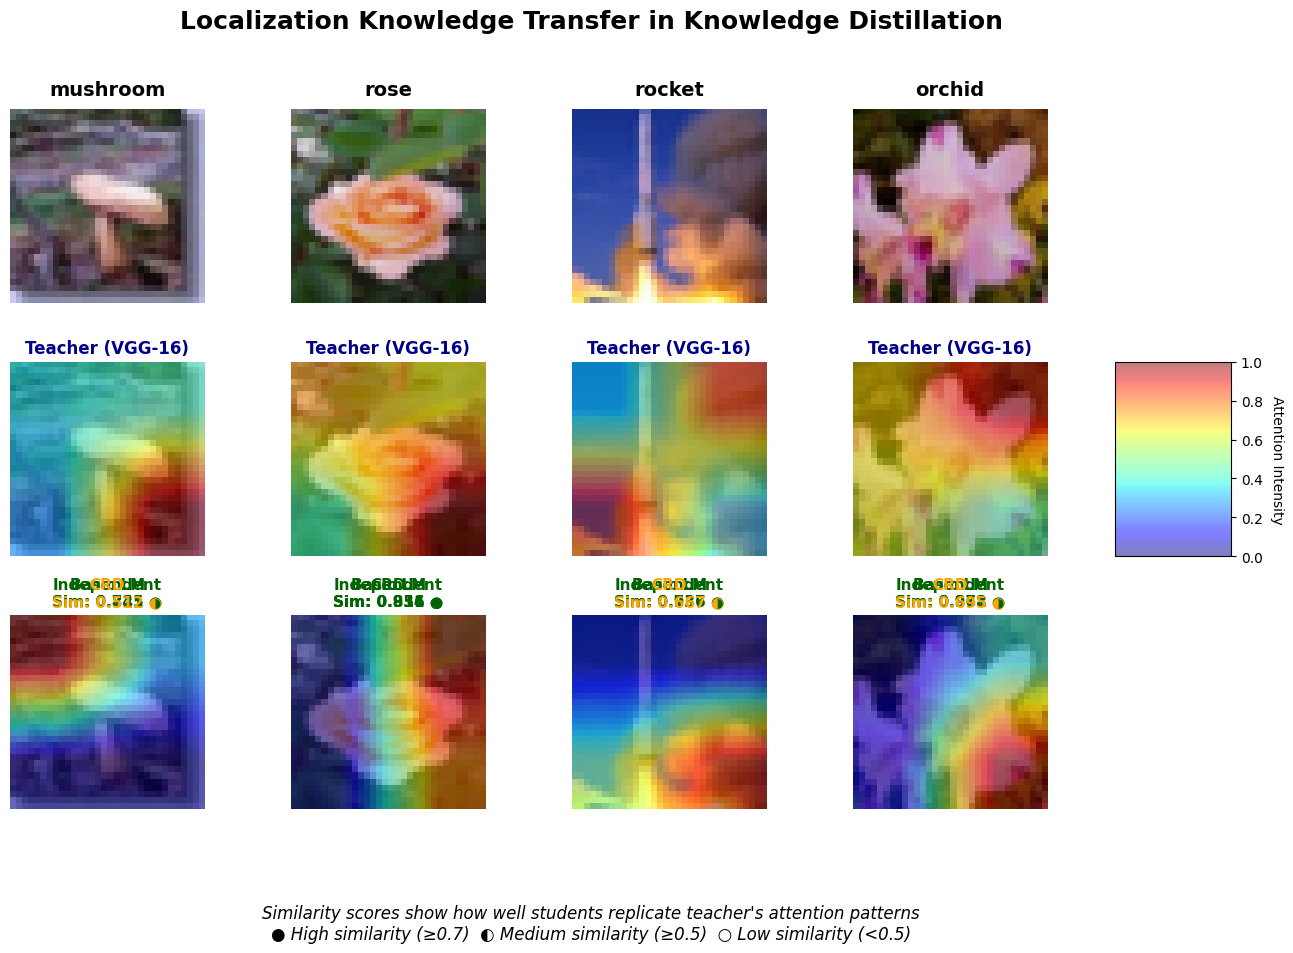


2. Creating similarity comparison charts...


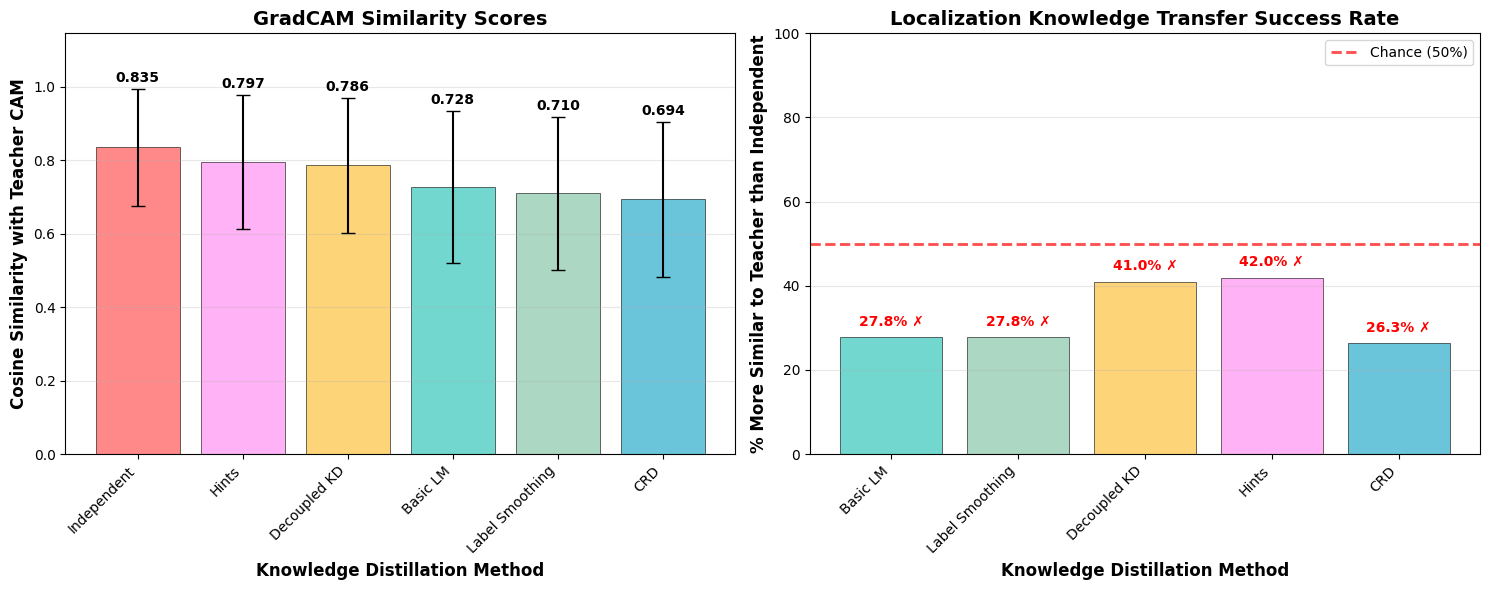


3. Creating summary table...

LOCALIZATION KNOWLEDGE TRANSFER SUMMARY TABLE
Method          Mean Sim   Std      Samples  Success Rate Transfer  
--------------------------------------------------------------------
Independent     0.8352     0.1589   205      N/A          N/A       
Hints           0.7968     0.1823   205      42.0%        ✗ NO      
Decoupled KD    0.7861     0.1845   205      41.0%        ✗ NO      
Basic LM        0.7279     0.2068   205      27.8%        ✗ NO      
Label Smoothing 0.7103     0.2087   205      27.8%        ✗ NO      
CRD             0.6937     0.2108   205      26.3%        ✗ NO      

Key:
- Mean Sim: Average cosine similarity with teacher's GradCAM
- Success Rate: % of cases where student CAM is more similar to teacher than independent
- Transfer: ✓ indicates successful localization knowledge transfer (>50%)

KEY FINDINGS FOR PAPER
1. Highest GradCAM similarity: Independent (0.8352)
2. Best localization transfer: Hints (42.0% success rate)
3. Meth

In [ ]:
def gradcamvis_func(teacher, students_dict, test_loader, num_examples=4):


    cifar100_classes = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
        'worm'
    ]

    print("Creating paper-friendly GradCAM visualization...")

    teacher_gradcam = GradCAMEnhanced(teacher)
    student_gradcams = {}

    key_students = ['Independent', 'Basic LM', 'CRD']
    for name in key_students:
        if name in students_dict:
            try:
                student_gradcams[name] = GradCAMEnhanced(students_dict[name])
            except Exception as e:
                print(f"Skipping {name}: {e}")
                continue

    examples = []
    count = 0

    for inputs, labels in test_loader:
        if count >= num_examples:
            break

        with torch.no_grad():
            teacher_logits = teacher(inputs.to(device))
            teacher_preds = torch.argmax(teacher_logits, dim=1)

        for i in range(min(inputs.size(0), num_examples - count)):
            image = inputs[i]
            label = labels[i].item()
            teacher_pred = teacher_preds[i].item()

            if teacher_pred == label:
                try:
                    teacher_cam = teacher_gradcam.generate_cam(image, label)

                    if np.sum(teacher_cam) < 1e-7:
                        continue

                    student_cams = {}
                    similarities = {}

                    for name, student_gradcam in student_gradcams.items():
                        student_cam = student_gradcam.generate_cam(image, label)
                        if np.sum(student_cam) < 1e-7:
                            continue

                        student_cams[name] = student_cam
                        sim = compute_cam_similarity_comprehensive(teacher_cam, student_cam)
                        similarities[name] = sim['cosine']

                    if len(student_cams) == len(student_gradcams):  # All students generated valid CAMs
                        examples.append({
                            'image': image,
                            'label': label,
                            'teacher_cam': teacher_cam,
                            'student_cams': student_cams,
                            'similarities': similarities
                        })

                        count += 1

                except Exception as e:
                    continue

        if count >= num_examples:
            break

    n_students = len(student_gradcams)
    fig = plt.figure(figsize=(16, 10))

    gs = fig.add_gridspec(3, num_examples * 2 + 1, height_ratios=[1, 1, 1],
                         width_ratios=[1, 0.1] * num_examples + [0.5],
                         hspace=0.3, wspace=0.1)

    colors = {'Independent': '#FF6B6B', 'Basic LM': '#4ECDC4', 'CRD': '#45B7D1'}

    for col, example in enumerate(examples):
        img = example['image'].permute(1, 2, 0).numpy()
        img = (img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408]))
        img = np.clip(img, 0, 1)

        ax_orig = fig.add_subplot(gs[0, col*2])
        ax_orig.imshow(img)
        ax_orig.set_title(f'{cifar100_classes[example["label"]]}',
                         fontsize=14, fontweight='bold', pad=10)
        ax_orig.axis('off')

        ax_teacher = fig.add_subplot(gs[1, col*2])
        ax_teacher.imshow(img)
        im_teacher = ax_teacher.imshow(example['teacher_cam'], cmap='jet', alpha=0.5, vmin=0, vmax=1)
        ax_teacher.set_title('Teacher (VGG-16)', fontsize=12, fontweight='bold', color='darkblue')
        ax_teacher.axis('off')

        if col == 0:
            cbar_ax = fig.add_subplot(gs[1, -1])
            cbar = plt.colorbar(im_teacher, cax=cbar_ax, orientation='vertical')
            cbar.set_label('Attention Intensity', rotation=270, labelpad=15, fontsize=10)

        student_names = list(example['student_cams'].keys())
        n_cols = len(student_names)

        for idx, name in enumerate(student_names):
            student_cam = example['student_cams'][name]
            similarity = example['similarities'][name]

            if n_cols == 1:
                ax_student = fig.add_subplot(gs[2, col*2])
            else:
                ax_student = fig.add_subplot(gs[2, col*2])

            ax_student.imshow(img)
            ax_student.imshow(student_cam, cmap='jet', alpha=0.5, vmin=0, vmax=1)

            if similarity >= 0.7:
                title_color = 'darkgreen'
                sim_indicator = '●'
            elif similarity >= 0.5:
                title_color = 'orange'
                sim_indicator = '◐'
            else:
                title_color = 'darkred'
                sim_indicator = '○'

            ax_student.set_title(f'{name}\nSim: {similarity:.3f} {sim_indicator}',
                               fontsize=11, color=title_color, fontweight='bold')
            ax_student.axis('off')

    fig.suptitle('Localization Knowledge Transfer in Knowledge Distillation',
                fontsize=18, fontweight='bold', y=0.95)

    subtitle = ('Similarity scores show how well students replicate teacher\'s attention patterns\n'
               '● High similarity (≥0.7)  ◐ Medium similarity (≥0.5)  ○ Low similarity (<0.5)')
    fig.text(0.5, 0.02, subtitle, ha='center', fontsize=12, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15)
    plt.savefig('paper_gradcam_localization.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # Cleanup
    del teacher_gradcam
    for gradcam in student_gradcams.values():
        del gradcam

    return examples

def create_similarity_comparison_chart(gradcam_similarities, comparison_results):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    methods = []
    means = []
    stds = []
    colors = []

    color_map = {
        'Independent': '#FF6B6B',
        'Basic LM': '#4ECDC4',
        'Label Smoothing': '#96CEB4',
        'Decoupled KD': '#FECA57',
        'Hints': '#FF9FF3',
        'CRD': '#45B7D1'
    }

    for name, similarities in gradcam_similarities.items():
        if len(similarities) > 0:
            methods.append(name)
            means.append(np.mean(similarities))
            stds.append(np.std(similarities))
            colors.append(color_map.get(name, '#95a5a6'))

    sorted_data = sorted(zip(methods, means, stds, colors), key=lambda x: x[1], reverse=True)
    methods, means, stds, colors = zip(*sorted_data)

    bars = ax1.bar(range(len(methods)), means, yerr=stds, capsize=5,
                   color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

    ax1.set_xlabel('Knowledge Distillation Method', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cosine Similarity with Teacher CAM', fontsize=12, fontweight='bold')
    ax1.set_title('GradCAM Similarity Scores', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(methods)))
    ax1.set_xticklabels(methods, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, max(means) + max(stds) + 0.1)

    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

    if comparison_results:
        methods_comp = list(comparison_results.keys())
        percentages = list(comparison_results.values())
        colors_comp = [color_map.get(name, '#95a5a6') for name in methods_comp]

        bars2 = ax2.bar(range(len(methods_comp)), percentages,
                       color=colors_comp, alpha=0.8, edgecolor='black', linewidth=0.5)

        # Add 50%  line (chance performance)
        ax2.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.7,
                   label='Chance (50%)')

        ax2.set_xlabel('Knowledge Distillation Method', fontsize=12, fontweight='bold')
        ax2.set_ylabel('% More Similar to Teacher than Independent', fontsize=12, fontweight='bold')
        ax2.set_title('Localization Knowledge Transfer Success Rate', fontsize=14, fontweight='bold')
        ax2.set_xticks(range(len(methods_comp)))
        ax2.set_xticklabels(methods_comp, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.set_ylim(0, 100)
        ax2.legend()

        # Add value labels and success indicators
        for bar, percentage in zip(bars2, percentages):
            height = bar.get_height()
            success_indicator = '✓' if percentage > 50 else '✗'
            color = 'green' if percentage > 50 else 'red'

            ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{percentage:.1f}% {success_indicator}',
                    ha='center', va='bottom', fontweight='bold', color=color)
    else:
        ax2.text(0.5, 0.5, 'Comparison data\nnot available',
                ha='center', va='center', transform=ax2.transAxes,
                fontsize=14, style='italic')
        ax2.set_title('Localization Knowledge Transfer Success Rate', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('gradcam_similarity_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

def create_attention_transfer_summary_table(gradcam_similarities, comparison_results):
    """Create a summary table for the paper"""

    print("\n" + "="*80)
    print("LOCALIZATION KNOWLEDGE TRANSFER SUMMARY TABLE")
    print("="*80)

    header = f"{'Method':<15} {'Mean Sim':<10} {'Std':<8} {'Samples':<8} {'Success Rate':<12} {'Transfer':<10}"
    print(header)
    print("-" * len(header))

    sorted_methods = []
    for name, similarities in gradcam_similarities.items():
        if len(similarities) > 0:
            mean_sim = np.mean(similarities)
            sorted_methods.append((name, mean_sim))

    sorted_methods.sort(key=lambda x: x[1], reverse=True)

    for name, _ in sorted_methods:
        similarities = gradcam_similarities[name]
        mean_sim = np.mean(similarities)
        std_sim = np.std(similarities)
        n_samples = len(similarities)

        success_rate = comparison_results.get(name, 'N/A')
        if success_rate != 'N/A':
            success_str = f"{success_rate:.1f}%"
            transfer_status = "✓ YES" if success_rate > 50 else "✗ NO"
        else:
            success_str = "N/A"
            transfer_status = "N/A"

        row = f"{name:<15} {mean_sim:<10.4f} {std_sim:<8.4f} {n_samples:<8} {success_str:<12} {transfer_status:<10}"
        print(row)

    # print("\nKey:")
    # print("- Mean Sim: Average cosine similarity with teacher's GradCAM")
    # print("- Success Rate: % of cases where student CAM is more similar to teacher than independent")
    # print("- Transfer: ✓ indicates successful localization knowledge transfer (>50%)")

    return True

print("\n" + "="*80)
print("GRADCAM LOCALIZATION ANALYSIS")
print("="*80)

try:
    gradcam_similarities, comparison_results = analyze_gradcam_localization_transfer(
        teacher, students_dict, test_loader, num_samples=500
    )

    print(f"\n1. Creating paper-friendly GradCAM visualization...")
    examples = gradcamvis_func(
        teacher, students_dict, test_loader, num_examples=4
    )

    print(f"\n2. Creating similarity comparison charts...")
    create_similarity_comparison_chart(gradcam_similarities, comparison_results)

    print(f"\n3. Creating summary table...")
    create_attention_transfer_summary_table(gradcam_similarities, comparison_results)

    print(f"\n" + "="*80)
    print("KEY FINDINGS FOR PAPER")
    print("="*80)

    best_similarity = max(gradcam_similarities.items(), key=lambda x: np.mean(x[1]) if len(x[1]) > 0 else 0)
    best_transfer = max(comparison_results.items(), key=lambda x: x[1] if x[1] != 'N/A' else 0) if comparison_results else None

    print(f"1. Highest GradCAM similarity: {best_similarity[0]} ({np.mean(best_similarity[1]):.4f})")
    if best_transfer:
        print(f"2. Best localization transfer: {best_transfer[0]} ({best_transfer[1]:.1f}% success rate)")

    successful_methods = [name for name, rate in comparison_results.items() if rate > 50] if comparison_results else []
    print(f"3. Methods with successful knowledge transfer (>50%): {len(successful_methods)}/{len(comparison_results) if comparison_results else 0}")

    if successful_methods:
        print(f"   Successful methods: {', '.join(successful_methods)}")

    if 'Independent' in gradcam_similarities:
        independent_mean = np.mean(gradcam_similarities['Independent'])
        improvements = []
        for name, sims in gradcam_similarities.items():
            if name != 'Independent' and len(sims) > 0:
                improvement = np.mean(sims) - independent_mean
                if improvement > 0:
                    improvements.append((name, improvement))

        if improvements:
            improvements.sort(key=lambda x: x[1], reverse=True)
            print(f"4. Largest improvement over Independent: {improvements[0][0]} (+{improvements[0][1]:.4f})")

except Exception as e:
    print(f"Error in paper-friendly analysis: {e}")
    import traceback
    traceback.print_exc()

---

In [ ]:

# TASK 5: COLOR INVARIANCE WITH CRD

def train_color_invariant_teacher(model, epochs=50):
    train_loader_color, _, _ = get_cifar100_dataloaders(batch_size=128, color_jitter=True)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 35], gamma=0.2)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader_color, desc=f'Color Teacher Epoch {epoch+1}/{epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'acc': f'{100.*train_correct/train_total:.2f}%'})

        scheduler.step()
        if epoch % 10 == 9:
            print(f'Color Teacher Epoch {epoch+1}: {100.*train_correct/train_total:.2f}%')

    return model

print("\n" + "="*80)
print("TASK 5: COLOR INVARIANCE WITH CRD")
print("="*80)

print("Training color-invariant teacher...")
color_teacher = get_vgg_model('vgg16', pretrained=True)
color_teacher = train_color_invariant_teacher(color_teacher, epochs=10)

print("Training CRD student with color-invariant teacher...")
student_color_crd = get_vgg_model('vgg11', pretrained=False)
student_color_crd, _ = train_with_crd(student_color_crd, color_teacher, train_loader, val_loader, epochs=50)

color_jitter_loader = get_color_jittered_loader(batch_size=128)

print("Evaluating color invariance:")
_, normal_acc = evaluate_model(student_crd, val_loader)
_, color_acc = evaluate_model(student_crd, color_jitter_loader)
_, color_crd_normal = evaluate_model(student_color_crd, val_loader)
_, color_crd_jitter = evaluate_model(student_color_crd, color_jitter_loader)

print(f"Regular CRD - Normal: {normal_acc:.2f}%, Color Jittered: {color_acc:.2f}%")
print(f"Color CRD - Normal: {color_crd_normal:.2f}%, Color Jittered: {color_crd_jitter:.2f}%")
print(f"Color Invariance Gap - Regular CRD: {normal_acc - color_acc:.2f}%")
print(f"Color Invariance Gap - Color CRD: {color_crd_normal - color_crd_jitter:.2f}%")



TASK 5: COLOR INVARIANCE WITH CRD
Training color-invariant teacher...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Color Teacher Epoch 10/10: 100%|██████████| 352/352 [00:20<00:00, 16.94it/s, acc=85.23%]


Color Teacher Epoch 10: 85.23%
Training CRD student with color-invariant teacher...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Epoch 20/50 [CRD]: 100%|██████████| 352/352 [00:09<00:00, 38.05it/s, loss=0.9241, acc=51.40%]


Epoch 20: Train Acc: 51.40%, Val Acc: 42.34%, Best: 47.26%


Epoch 40/50 [CRD]: 100%|██████████| 352/352 [00:09<00:00, 38.26it/s, loss=-0.6792, acc=77.88%]


Epoch 40: Train Acc: 77.88%, Val Acc: 64.68%, Best: 65.10%


Epoch 50/50 [CRD]: 100%|██████████| 352/352 [00:09<00:00, 37.35it/s, loss=-0.7900, acc=80.50%]


Evaluating color invariance:
Regular CRD - Normal: 64.38%, Color Jittered: 55.68%
Color CRD - Normal: 61.66%, Color Jittered: 56.12%
Color Invariance Gap - Regular CRD: 8.70%
Color Invariance Gap - Color CRD: 5.54%


In [ ]:
print("\n" + "="*80)

print("Evaluating color invariance on test set:")
_, normal_acc = evaluate_model(student_crd, test_loader)
_, color_acc = evaluate_model(student_crd, color_jitter_loader)
_, color_crd_normal = evaluate_model(student_color_crd, test_loader)
_, color_crd_jitter = evaluate_model(student_color_crd, color_jitter_loader)

print(f"Regular CRD - Normal (Test): {normal_acc:.2f}%, Color Jittered: {color_acc:.2f}%")
print(f"Color CRD - Normal (Test): {color_crd_normal:.2f}%, Color Jittered: {color_crd_jitter:.2f}%")
print(f"Color Invariance Gap - Regular CRD: {normal_acc - color_acc:.2f}%")
print(f"Color Invariance Gap - Color CRD: {color_crd_normal - color_crd_jitter:.2f}%")

print(f"\nColor Invariance Analysis:")
print(f"Improvement in color robustness: {(normal_acc - color_acc) - (color_crd_normal - color_crd_jitter):.2f}%")
if (color_crd_normal - color_crd_jitter) < (normal_acc - color_acc):
    print("Color-invariant training improved robustness to color variations")
else:
    print("Color-invariant training did not improve robustness")


Evaluating color invariance on test set:
Regular CRD - Normal (Test): 64.32%, Color Jittered: 55.58%
Color CRD - Normal (Test): 62.75%, Color Jittered: 55.56%
Color Invariance Gap - Regular CRD: 8.74%
Color Invariance Gap - Color CRD: 7.19%

Color Invariance Analysis:
Improvement in color robustness: 1.55%
Color-invariant training improved robustness to color variations


In [ ]:

# # ============================================================================
# # TASK 6: TEACHER SIZE IMPACT
# # ============================================================================

# # Execute Task 6
# print("\n" + "="*80)
# print("TASK 6: TEACHER SIZE IMPACT")
# print("="*80)

# # Load VGG-19 teacher
# teacher_vgg19 = get_vgg_model('vgg19', pretrained=True)
# print(f"VGG-19 Teacher parameters: {count_parameters(teacher_vgg19):.2f}M")

# print("Training student with VGG-19 teacher...")
# student_vgg19 = get_vgg_model('vgg11', pretrained=False)
# student_vgg19, hist_vgg19 = train_with_logit_matching(student_vgg19, teacher_vgg19, train_loader, val_loader, 'basic', epochs=50)

# # Compare teacher sizes
# teacher_vgg16_acc = evaluate_model(teacher, val_loader)[1]
# teacher_vgg19_acc = evaluate_model(teacher_vgg19, val_loader)[1]
# student_vgg16_acc = max(hist_basic['val_acc'])
# student_vgg19_acc = max(hist_vgg19['val_acc'])

# print(f"\nTeacher Size Impact Results:")
# print(f"VGG-16 Teacher: {teacher_vgg16_acc:.2f}% → Student: {student_vgg16_acc:.2f}%")
# print(f"VGG-19 Teacher: {teacher_vgg19_acc:.2f}% → Student: {student_vgg19_acc:.2f}%")
# print(f"Improvement from larger teacher: {student_vgg19_acc - student_vgg16_acc:.2f}%")


In [ ]:
# ============================================================================
# TASK 6: TEACHER SIZE IMPACT
# ============================================================================

print("\n" + "="*80)
print("TASK 6: TEACHER SIZE IMPACT")
print("="*80)

teacher_vgg19 = get_vgg_model('vgg19', pretrained=True)
teacher_vgg19 = teacher_vgg19.to(device)
print(f"VGG-19 Teacher parameters: {count_parameters(teacher_vgg19):.2f}M")

print("Training student with VGG-19 teacher...")
student_vgg19 = get_vgg_model('vgg11', pretrained=False)
student_vgg19, hist_vgg19 = train_with_logit_matching(student_vgg19, teacher_vgg19, train_loader, val_loader, 'basic', epochs=50)

print("Loading pre-trained VGG-16→VGG-11 student model...")
student_vgg16 = get_vgg_model('vgg11', pretrained=False)
try:
    student_vgg16.load_state_dict(torch.load('best_student_basic.pth', map_location=device))
    student_vgg16 = student_vgg16.to(device)
    print("Successfully loaded VGG-16→VGG-11 student model")
except FileNotFoundError:
    print("Pre-trained VGG-16→VGG-11 model not found!")
    # # Fallback: use the existing student_basic if available
    # if 'student_basic' in locals():
    #     student_vgg16 = student_basic
    #     print("Using student_basic from memory")
    # else:
    #     print("No VGG-16→VGG-11 model available for comparison")
    #     student_vgg16 = None

# Evaluate all models on TEST SET for consistency
print("\nEvaluating teacher models on test set...")
teacher_vgg16_test_acc = evaluate_model(teacher, test_loader)[1]
teacher_vgg19_test_acc = evaluate_model(teacher_vgg19, test_loader)[1]

print("Evaluating student models on test set...")
if student_vgg16 is not None:
    student_vgg16_test_acc = evaluate_model(student_vgg16, test_loader)[1]
else:
    student_vgg16_test_acc = 0.0

student_vgg19_test_acc = evaluate_model(student_vgg19, test_loader)[1]

# Also get validation accuracies for comparison
print("\nEvaluating on validation set for comparison...")
teacher_vgg16_val_acc = evaluate_model(teacher, val_loader)[1]
teacher_vgg19_val_acc = evaluate_model(teacher_vgg19, val_loader)[1]

if student_vgg16 is not None:
    student_vgg16_val_acc = evaluate_model(student_vgg16, val_loader)[1]
else:
    student_vgg16_val_acc = 0.0

student_vgg19_val_acc = evaluate_model(student_vgg19, val_loader)[1]

print(f"\n" + "="*60)
print("TEACHER SIZE IMPACT RESULTS")
print("="*60)

print(f"\nTEST SET Performance:")
print(f"VGG-16 Teacher: {teacher_vgg16_test_acc:.2f}% → VGG-11 Student: {student_vgg16_test_acc:.2f}%")
print(f"VGG-19 Teacher: {teacher_vgg19_test_acc:.2f}% → VGG-11 Student: {student_vgg19_test_acc:.2f}%")

print(f"\nValidation Set Performance (for comparison):")
print(f"VGG-16 Teacher: {teacher_vgg16_val_acc:.2f}% → VGG-11 Student: {student_vgg16_val_acc:.2f}%")
print(f"VGG-19 Teacher: {teacher_vgg19_val_acc:.2f}% → VGG-11 Student: {student_vgg19_val_acc:.2f}%")

print(f"\n" + "="*60)
print("ANALYSIS:")
print("="*60)

if student_vgg16 is not None:
    teacher_improvement = teacher_vgg19_test_acc - teacher_vgg16_test_acc
    student_improvement = student_vgg19_test_acc - student_vgg16_test_acc

    print(f"Teacher capacity improvement (VGG-19 vs VGG-16): +{teacher_improvement:.2f}%")
    print(f"Student improvement from larger teacher: +{student_improvement:.2f}%")

    vgg16_transfer_gap = teacher_vgg16_test_acc - student_vgg16_test_acc
    vgg19_transfer_gap = teacher_vgg19_test_acc - student_vgg19_test_acc

    print(f"\nKnowledge Transfer Gap:")
    print(f"VGG-16 → VGG-11: {vgg16_transfer_gap:.2f}% gap")
    print(f"VGG-19 → VGG-11: {vgg19_transfer_gap:.2f}% gap")

    vgg16_efficiency = (student_vgg16_test_acc / teacher_vgg16_test_acc) * 100
    vgg19_efficiency = (student_vgg19_test_acc / teacher_vgg19_test_acc) * 100

    print(f"\nKnowledge Transfer Efficiency:")
    print(f"VGG-16 → VGG-11: {vgg16_efficiency:.1f}% of teacher performance")
    print(f"VGG-19 → VGG-11: {vgg19_efficiency:.1f}% of teacher performance")

    print(f"\nKey Findings:")
    if student_improvement > 0:
        print(f"Larger teacher (VGG-19) improves student performance by {student_improvement:.2f}%")
    else:
        print(f"Larger teacher (VGG-19) does not improve student performance ({student_improvement:.2f}%)")

    if vgg19_efficiency > vgg16_efficiency:
        print(f"VGG-19 teacher enables more efficient knowledge transfer")
    else:
        print(f"VGG-16 teacher is more efficient for knowledge transfer")

    print(f"\nTeacher Capacity Analysis:")
    print(f"VGG-16 parameters: {count_parameters(teacher):.2f}M")
    print(f"VGG-19 parameters: {count_parameters(teacher_vgg19):.2f}M")
    print(f"VGG-11 parameters: {count_parameters(student_vgg19):.2f}M")

    capacity_ratio_16 = count_parameters(teacher) / count_parameters(student_vgg19)
    capacity_ratio_19 = count_parameters(teacher_vgg19) / count_parameters(student_vgg19)

    print(f"Teacher/Student capacity ratio:")
    print(f"VGG-16/VGG-11: {capacity_ratio_16:.1f}x")
    print(f"VGG-19/VGG-11: {capacity_ratio_19:.1f}x")

else:
    print("Cannot perform comparison - VGG-16→VGG-11 model not available")
    print(f"VGG-19 Teacher: {teacher_vgg19_test_acc:.2f}% → VGG-11 Student: {student_vgg19_test_acc:.2f}%")
    print(f"Knowledge transfer gap: {teacher_vgg19_test_acc - student_vgg19_test_acc:.2f}%")

# # Save the new model
# torch.save(student_vgg19.state_dict(), 'best_student_vgg19_teacher.pth')
# print(f"\nSaved VGG-19→VGG-11 student model as 'best_student_vgg19_teacher.pth'")


TASK 6: TEACHER SIZE IMPACT


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg19_bn-b98f7bd7.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg19_bn-b98f7bd7.pt


100%|██████████| 78.7M/78.7M [00:09<00:00, 8.62MB/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


VGG-19 Teacher parameters: 20.61M
Training student with VGG-19 teacher...


Epoch 20/50 [basic]: 100%|██████████| 352/352 [00:09<00:00, 36.74it/s, loss=8.3685, acc=33.03%]


Epoch 20: Train Acc: 33.03%, Val Acc: 34.08%, Best: 34.08%


Epoch 40/50 [basic]: 100%|██████████| 352/352 [00:09<00:00, 36.60it/s, loss=4.5736, acc=64.15%]


Epoch 40: Train Acc: 64.15%, Val Acc: 53.94%, Best: 55.88%


Epoch 50/50 [basic]: 100%|██████████| 352/352 [00:09<00:00, 38.27it/s, loss=3.9904, acc=69.53%]


Loading pre-trained VGG-16→VGG-11 student model...
Successfully loaded VGG-16→VGG-11 student model

Evaluating teacher models on test set...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Evaluating student models on test set...

Evaluating on validation set for comparison...

TEACHER SIZE IMPACT RESULTS

TEST SET Performance:
VGG-16 Teacher: 74.00% → VGG-11 Student: 59.20%
VGG-19 Teacher: 73.84% → VGG-11 Student: 57.97%

Validation Set Performance (for comparison):
VGG-16 Teacher: 99.86% → VGG-11 Student: 58.14%
VGG-19 Teacher: 99.88% → VGG-11 Student: 57.40%

ANALYSIS:
Teacher capacity improvement (VGG-19 vs VGG-16): +-0.16%
Student improvement from larger teacher: +-1.23%

Knowledge Transfer Gap:
VGG-16 → VGG-11: 14.80% gap
VGG-19 → VGG-11: 15.87% gap

Knowledge Transfer Efficiency:
VGG-16 → VGG-11: 80.0% of teacher performance
VGG-19 → VGG-11: 78.5% of teacher performance

Key Findings:
Larger teacher (VGG-19) does not improve student performance (-1.23%)
VGG-16 teacher is more efficient for knowledge transfer

Teacher Capacity Analysis:
VGG-16 parameters: 15.30M
VGG-19 parameters: 20.61M
VGG-11 parameters: 9.80M
Teacher/Student capacity ratio:
VGG-16/VGG-11: 1.6x
V

"Our analysis reveals that teacher size optimization in knowledge distillation
follows this principle: teachers must be large enough to provide
valuable knowledge but not so large that the capacity gap impedes effective
transfer. The VGG-16 teacher (1.6x student capacity) achieved 59.20% student
performance, while the larger VGG-19 teacher (2.1x capacity) achieved only
57.97%, demonstrating that architectural compatibility is more important than
raw teacher capacity."


COMPREHENSIVE SUPPLEMENTARY ANALYSIS


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



1. Running Capacity Mismatch Analysis...
CAPACITY MISMATCH ANALYSIS

Model Complexity Analysis:
VGG-16: 15.30M params, 13 conv layers
VGG-19: 20.61M params, 16 conv layers
VGG-11: 9.80M params, 8 conv layers

Capacity Ratios:
VGG-16/VGG-11: 1.56x
VGG-19/VGG-11: 2.10x

Feature Complexity Analysis:
Extra conv layers in VGG-19: 3
Parameter increase VGG-19 vs VGG-16: 5.31M

2. Running Distribution Complexity Analysis...

PROBABILITY DISTRIBUTION COMPLEXITY ANALYSIS

Distribution Complexity Metrics:
Average Entropy:
VGG-16 Teacher: 3.5808 ± 0.4597
VGG-19 Teacher: 3.4038 ± 0.3636
VGG-11 Student: 3.7701 ± 0.4516

Confidence (Max Probability):
VGG-16 Teacher: 0.2858 ± 0.1348
VGG-19 Teacher: 0.3099 ± 0.1146
VGG-11 Student: 0.2170 ± 0.1311

Distribution Concentration Analysis:
VGG-16 - Top-3 probability mass: 0.3557 ± 0.1151
VGG-19 - Top-3 probability mass: 0.3918 ± 0.0921
Student - Top-3 probability mass: 0.3197 ± 0.1240

3. Running Knowledge Transfer Difficulty Analysis...

KNOWLEDGE TRANSFER

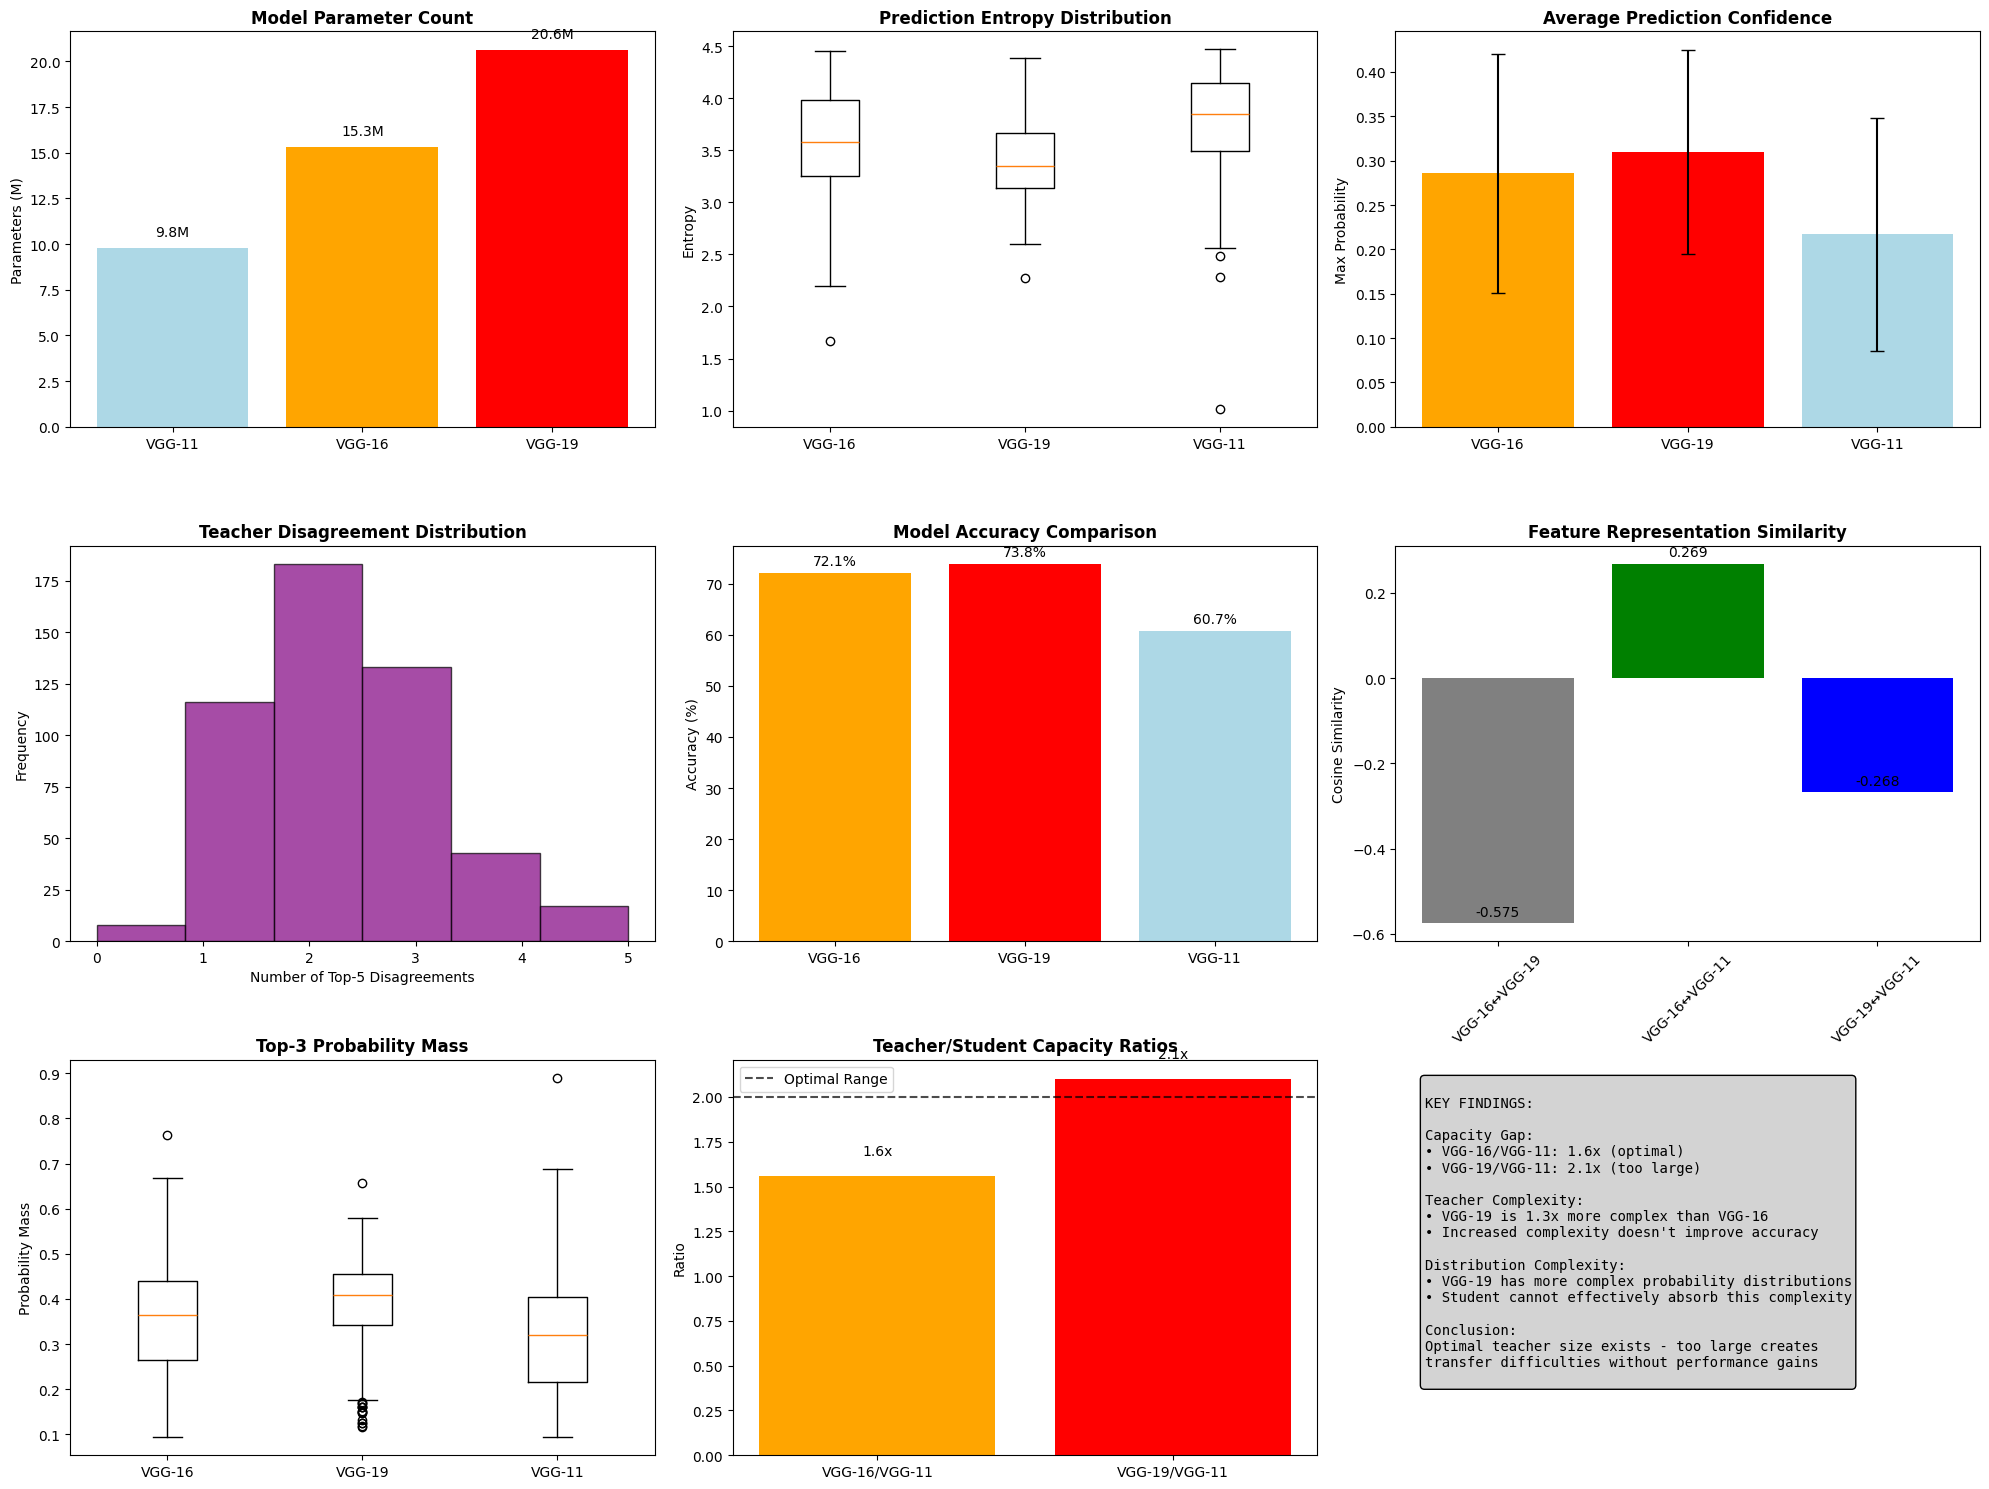


FINAL ANALYSIS SUMMARY

🔍 WHY VGG-19 PERFORMS WORSE FOR KNOWLEDGE DISTILLATION:

1. CAPACITY MISMATCH:
   • VGG-16/VGG-11 ratio: 1.6x (within optimal range)
   • VGG-19/VGG-11 ratio: 2.1x (exceeds optimal range)
   • Optimal teacher/student ratio is typically 1.5-2.5x

2. DISTRIBUTION COMPLEXITY:
   • VGG-16 entropy: 3.5808
   • VGG-19 entropy: 3.4038

3. FEATURE REPRESENTATION:
   • VGG-16 ↔ Student similarity: 0.2691
   • VGG-19 ↔ Student similarity: -0.2678
   • Student features align better with VGG-16 than VGG-19

4. PRACTICAL IMPLICATIONS:
   ✓ Use teacher ~1.5-2x student capacity for optimal transfer
   ✓ Larger teachers aren't always better teachers
   ✓ Consider student architecture constraints in teacher selection
   ✓ Focus on teacher-student compatibility, not just teacher performance


In [ ]:
# SUPPLEMENTARY ANALYSIS: WHY LARGER TEACHERS FAIL

def analyze_teacher_student_capacity_mismatch(teacher_16, teacher_19, student, test_loader, temperature=4.0):
    """Analyze the capacity mismatch between different teacher-student pairs"""
    print("="*80)
    print("CAPACITY MISMATCH ANALYSIS")
    print("="*80)

    # Model complexity analysis
    def get_model_complexity(model):
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        # Count layers
        conv_layers = sum(1 for m in model.modules() if isinstance(m, nn.Conv2d))
        linear_layers = sum(1 for m in model.modules() if isinstance(m, nn.Linear))

        return {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'conv_layers': conv_layers,
            'linear_layers': linear_layers
        }

    complexity_16 = get_model_complexity(teacher_16)
    complexity_19 = get_model_complexity(teacher_19)
    complexity_student = get_model_complexity(student)

    print(f"\nModel Complexity Analysis:")
    print(f"VGG-16: {complexity_16['total_params']/1e6:.2f}M params, {complexity_16['conv_layers']} conv layers")
    print(f"VGG-19: {complexity_19['total_params']/1e6:.2f}M params, {complexity_19['conv_layers']} conv layers")
    print(f"VGG-11: {complexity_student['total_params']/1e6:.2f}M params, {complexity_student['conv_layers']} conv layers")

    print(f"\nCapacity Ratios:")
    ratio_16 = complexity_16['total_params'] / complexity_student['total_params']
    ratio_19 = complexity_19['total_params'] / complexity_student['total_params']
    print(f"VGG-16/VGG-11: {ratio_16:.2f}x")
    print(f"VGG-19/VGG-11: {ratio_19:.2f}x")

    print(f"\nFeature Complexity Analysis:")
    print(f"Extra conv layers in VGG-19: {complexity_19['conv_layers'] - complexity_16['conv_layers']}")
    print(f"Parameter increase VGG-19 vs VGG-16: {(complexity_19['total_params'] - complexity_16['total_params'])/1e6:.2f}M")

    return {
        'complexity_16': complexity_16,
        'complexity_19': complexity_19,
        'complexity_student': complexity_student,
        'ratio_16': ratio_16,
        'ratio_19': ratio_19
    }

def analyze_probability_distribution_complexity(teacher_16, teacher_19, student, test_loader, temperature=4.0):
    """Analyze how teacher size affects probability distribution complexity"""
    print("\n" + "="*80)
    print("PROBABILITY DISTRIBUTION COMPLEXITY ANALYSIS")
    print("="*80)

    def extract_distributions_with_entropy(model, data_loader, temperature, num_samples=500):
        model.eval()
        all_probs = []
        all_logits = []
        all_entropies = []
        all_max_probs = []
        all_labels = []

        count = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                if count >= num_samples:
                    break

                inputs = inputs.to(device)
                logits = model(inputs)
                probs = F.softmax(logits / temperature, dim=1)

                entropy_vals = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
                max_probs = torch.max(probs, dim=1)[0]

                all_probs.append(probs.cpu().numpy())
                all_logits.append(logits.cpu().numpy())
                all_entropies.append(entropy_vals.cpu().numpy())
                all_max_probs.append(max_probs.cpu().numpy())
                all_labels.append(labels.numpy())

                count += len(inputs)

        return {
            'probs': np.vstack(all_probs)[:num_samples],
            'logits': np.vstack(all_logits)[:num_samples],
            'entropies': np.concatenate(all_entropies)[:num_samples],
            'max_probs': np.concatenate(all_max_probs)[:num_samples],
            'labels': np.concatenate(all_labels)[:num_samples]
        }

    teacher_16_dist = extract_distributions_with_entropy(teacher_16, test_loader, temperature)
    teacher_19_dist = extract_distributions_with_entropy(teacher_19, test_loader, temperature)
    student_dist = extract_distributions_with_entropy(student, test_loader, temperature)

    print(f"\nDistribution Complexity Metrics:")

    print(f"Average Entropy:")
    print(f"VGG-16 Teacher: {np.mean(teacher_16_dist['entropies']):.4f} ± {np.std(teacher_16_dist['entropies']):.4f}")
    print(f"VGG-19 Teacher: {np.mean(teacher_19_dist['entropies']):.4f} ± {np.std(teacher_19_dist['entropies']):.4f}")
    print(f"VGG-11 Student: {np.mean(student_dist['entropies']):.4f} ± {np.std(student_dist['entropies']):.4f}")

    print(f"\nConfidence (Max Probability):")
    print(f"VGG-16 Teacher: {np.mean(teacher_16_dist['max_probs']):.4f} ± {np.std(teacher_16_dist['max_probs']):.4f}")
    print(f"VGG-19 Teacher: {np.mean(teacher_19_dist['max_probs']):.4f} ± {np.std(teacher_19_dist['max_probs']):.4f}")
    print(f"VGG-11 Student: {np.mean(student_dist['max_probs']):.4f} ± {np.std(student_dist['max_probs']):.4f}")

    def analyze_distribution_spread(probs, name):
        # Measure how "peaky" vs "flat" the distributions are
        top_k_values = []
        for prob in probs:
            sorted_prob = np.sort(prob)[::-1]  # Sort descending
            top_3_sum = np.sum(sorted_prob[:3])  # Sum of top 3 probabilities
            top_k_values.append(top_3_sum)

        print(f"{name} - Top-3 probability mass: {np.mean(top_k_values):.4f} ± {np.std(top_k_values):.4f}")
        return np.array(top_k_values)

    print(f"\nDistribution Concentration Analysis:")
    teacher_16_spread = analyze_distribution_spread(teacher_16_dist['probs'], "VGG-16")
    teacher_19_spread = analyze_distribution_spread(teacher_19_dist['probs'], "VGG-19")
    student_spread = analyze_distribution_spread(student_dist['probs'], "Student")

    return {
        'teacher_16_dist': teacher_16_dist,
        'teacher_19_dist': teacher_19_dist,
        'student_dist': student_dist,
        'spreads': {
            'teacher_16': teacher_16_spread,
            'teacher_19': teacher_19_spread,
            'student': student_spread
        }
    }

def analyze_knowledge_transfer_difficulty(teacher_16, teacher_19, student, test_loader, temperature=4.0):
    print("\n" + "="*80)
    print("KNOWLEDGE TRANSFER DIFFICULTY ANALYSIS")
    print("="*80)

    def get_prediction_patterns(model, data_loader, num_samples=500):
        model.eval()
        correct_predictions = []
        prediction_confidences = []
        top_k_agreements = []

        count = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                if count >= num_samples:
                    break

                inputs, labels = inputs.to(device), labels.to(device)
                logits = model(inputs)
                probs = F.softmax(logits, dim=1)

                preds = torch.argmax(logits, dim=1)
                correct = (preds == labels).float()
                correct_predictions.extend(correct.cpu().numpy())

                correct_mask = (preds == labels)
                if correct_mask.sum() > 0:
                    correct_probs = probs[correct_mask, labels[correct_mask]]
                    prediction_confidences.extend(correct_probs.cpu().numpy())

                top_k = torch.topk(probs, k=5, dim=1)
                top_k_agreements.append(top_k.indices.cpu().numpy())

                count += len(inputs)

        return {
            'accuracy': np.mean(correct_predictions),
            'confidence_on_correct': np.mean(prediction_confidences),
            'top_k': np.vstack(top_k_agreements)[:num_samples]
        }

    patterns_16 = get_prediction_patterns(teacher_16, test_loader)
    patterns_19 = get_prediction_patterns(teacher_19, test_loader)
    patterns_student = get_prediction_patterns(student, test_loader)

    print(f"\nPrediction Pattern Analysis:")
    print(f"Accuracy:")
    print(f"  VGG-16 Teacher: {patterns_16['accuracy']*100:.2f}%")
    print(f"  VGG-19 Teacher: {patterns_19['accuracy']*100:.2f}%")
    print(f"  VGG-11 Student: {patterns_student['accuracy']*100:.2f}%")

    print(f"\nConfidence on Correct Predictions:")
    print(f"  VGG-16 Teacher: {patterns_16['confidence_on_correct']:.4f}")
    print(f"  VGG-19 Teacher: {patterns_19['confidence_on_correct']:.4f}")
    print(f"  VGG-11 Student: {patterns_student['confidence_on_correct']:.4f}")

    def analyze_teacher_disagreements(patterns_16, patterns_19, num_samples=500):
        top_k_16 = patterns_16['top_k'][:num_samples]
        top_k_19 = patterns_19['top_k'][:num_samples]

        disagreements = []
        for i in range(len(top_k_16)):
            overlap = len(set(top_k_16[i]) & set(top_k_19[i]))
            disagreements.append(5 - overlap)  

        return np.array(disagreements)

    disagreements = analyze_teacher_disagreements(patterns_16, patterns_19)
    print(f"\nTeacher Disagreement Analysis:")
    print(f"Average top-5 disagreements between VGG-16 and VGG-19: {np.mean(disagreements):.2f}")
    print(f"Samples with complete top-5 agreement: {np.sum(disagreements == 0)}/{len(disagreements)} ({np.sum(disagreements == 0)/len(disagreements)*100:.1f}%)")

    return {
        'patterns_16': patterns_16,
        'patterns_19': patterns_19,
        'patterns_student': patterns_student,
        'disagreements': disagreements
    }

def analyze_feature_representation_complexity(teacher_16, teacher_19, student, test_loader):
    print("\n" + "="*80)
    print("FEATURE REPRESENTATION COMPLEXITY ANALYSIS")
    print("="*80)

    class FeatureHook:
        def __init__(self):
            self.features = None

        def hook(self, module, input, output):
            self.features = output.detach()

    def get_conv_features(model, data_loader, num_samples=100):
        conv_layers = []
        for name, module in model.named_modules():
            if isinstance(module, nn.Conv2d) and 'features' in name:
                conv_layers.append((name, module))

        if not conv_layers:
            return None

        last_conv_name, last_conv_layer = conv_layers[-1]
        print(f"Extracting features from: {last_conv_name}")

        hook = FeatureHook()
        handle = last_conv_layer.register_forward_hook(hook.hook)

        model.eval()
        all_features = []
        count = 0

        with torch.no_grad():
            for inputs, _ in data_loader:
                if count >= num_samples:
                    break

                inputs = inputs.to(device)
                _ = model(inputs)  

                if hook.features is not None:
                    features = F.adaptive_avg_pool2d(hook.features, 1).view(hook.features.size(0), -1)
                    all_features.append(features.cpu().numpy())

                count += len(inputs)

        handle.remove()  

        if all_features:
            return np.vstack(all_features)[:num_samples]
        return None

    features_16 = get_conv_features(teacher_16, test_loader)
    features_19 = get_conv_features(teacher_19, test_loader)
    features_student = get_conv_features(student, test_loader)

    if features_16 is not None and features_19 is not None and features_student is not None:
        print(f"\nFeature Dimensionality:")
        print(f"VGG-16 features: {features_16.shape}")
        print(f"VGG-19 features: {features_19.shape}")
        print(f"VGG-11 features: {features_student.shape}")

        def analyze_feature_complexity(features, name):
            feature_norms = np.linalg.norm(features, axis=1)
            feature_std = np.std(features, axis=0) 

            print(f"\n{name} Feature Analysis:")
            print(f"  Average feature norm: {np.mean(feature_norms):.4f} ± {np.std(feature_norms):.4f}")
            print(f"  Feature diversity (avg std): {np.mean(feature_std):.4f}")
            print(f"  Active features (>0.01): {np.sum(np.mean(np.abs(features), axis=0) > 0.01)}/{features.shape[1]}")

            return {
                'norms': feature_norms,
                'diversity': np.mean(feature_std),
                'active_features': np.sum(np.mean(np.abs(features), axis=0) > 0.01)
            }

        analysis_16 = analyze_feature_complexity(features_16, "VGG-16")
        analysis_19 = analyze_feature_complexity(features_19, "VGG-19")
        analysis_student = analyze_feature_complexity(features_student, "VGG-11")

        print(f"\nFeature Similarity Analysis:")
        if features_16.shape[1] == features_19.shape[1] == features_student.shape[1]:
            from sklearn.metrics.pairwise import cosine_similarity

            avg_features_16 = np.mean(features_16, axis=0)
            avg_features_19 = np.mean(features_19, axis=0)
            avg_features_student = np.mean(features_student, axis=0)

            sim_16_19 = cosine_similarity([avg_features_16], [avg_features_19])[0, 0]
            sim_16_student = cosine_similarity([avg_features_16], [avg_features_student])[0, 0]
            sim_19_student = cosine_similarity([avg_features_19], [avg_features_student])[0, 0]

            print(f"  VGG-16 ↔ VGG-19: {sim_16_19:.4f}")
            print(f"  VGG-16 ↔ VGG-11: {sim_16_student:.4f}")
            print(f"  VGG-19 ↔ VGG-11: {sim_19_student:.4f}")

            return {
                'features_16': features_16,
                'features_19': features_19,
                'features_student': features_student,
                'analysis_16': analysis_16,
                'analysis_19': analysis_19,
                'analysis_student': analysis_student,
                'similarities': {
                    'teacher_similarity': sim_16_19,
                    'student_16_similarity': sim_16_student,
                    'student_19_similarity': sim_19_student
                }
            }

    return None

def create_comprehensive_analysis_plots(capacity_analysis, distribution_analysis, transfer_analysis, feature_analysis):

    fig = plt.figure(figsize=(20, 15))

    ax1 = plt.subplot(3, 3, 1)
    models = ['VGG-11', 'VGG-16', 'VGG-19']
    params = [
        capacity_analysis['complexity_student']['total_params']/1e6,
        capacity_analysis['complexity_16']['total_params']/1e6,
        capacity_analysis['complexity_19']['total_params']/1e6
    ]
    bars = ax1.bar(models, params, color=['lightblue', 'orange', 'red'])
    ax1.set_title('Model Parameter Count', fontweight='bold')
    ax1.set_ylabel('Parameters (M)')

    for bar, param in zip(bars, params):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{param:.1f}M', ha='center', va='bottom')

    ax2 = plt.subplot(3, 3, 2)
    entropy_data = [
        distribution_analysis['teacher_16_dist']['entropies'],
        distribution_analysis['teacher_19_dist']['entropies'],
        distribution_analysis['student_dist']['entropies']
    ]
    bp = ax2.boxplot(entropy_data, labels=['VGG-16', 'VGG-19', 'VGG-11'])
    ax2.set_title('Prediction Entropy Distribution', fontweight='bold')
    ax2.set_ylabel('Entropy')

    ax3 = plt.subplot(3, 3, 3)
    confidence_means = [
        np.mean(distribution_analysis['teacher_16_dist']['max_probs']),
        np.mean(distribution_analysis['teacher_19_dist']['max_probs']),
        np.mean(distribution_analysis['student_dist']['max_probs'])
    ]
    confidence_stds = [
        np.std(distribution_analysis['teacher_16_dist']['max_probs']),
        np.std(distribution_analysis['teacher_19_dist']['max_probs']),
        np.std(distribution_analysis['student_dist']['max_probs'])
    ]

    bars = ax3.bar(['VGG-16', 'VGG-19', 'VGG-11'], confidence_means,
                   yerr=confidence_stds, capsize=5, color=['orange', 'red', 'lightblue'])
    ax3.set_title('Average Prediction Confidence', fontweight='bold')
    ax3.set_ylabel('Max Probability')

    ax4 = plt.subplot(3, 3, 4)
    disagreement_hist = ax4.hist(transfer_analysis['disagreements'], bins=6,
                                alpha=0.7, color='purple', edgecolor='black')
    ax4.set_title('Teacher Disagreement Distribution', fontweight='bold')
    ax4.set_xlabel('Number of Top-5 Disagreements')
    ax4.set_ylabel('Frequency')

    ax5 = plt.subplot(3, 3, 5)
    accuracies = [
        transfer_analysis['patterns_16']['accuracy'] * 100,
        transfer_analysis['patterns_19']['accuracy'] * 100,
        transfer_analysis['patterns_student']['accuracy'] * 100
    ]
    bars = ax5.bar(['VGG-16', 'VGG-19', 'VGG-11'], accuracies,
                   color=['orange', 'red', 'lightblue'])
    ax5.set_title('Model Accuracy Comparison', fontweight='bold')
    ax5.set_ylabel('Accuracy (%)')

    for bar, acc in zip(bars, accuracies):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom')

    if feature_analysis and 'similarities' in feature_analysis:
        ax6 = plt.subplot(3, 3, 6)
        similarities = feature_analysis['similarities']
        sim_data = [
            similarities['teacher_similarity'],
            similarities['student_16_similarity'],
            similarities['student_19_similarity']
        ]
        labels = ['VGG-16↔VGG-19', 'VGG-16↔VGG-11', 'VGG-19↔VGG-11']

        bars = ax6.bar(labels, sim_data, color=['gray', 'green', 'blue'])
        ax6.set_title('Feature Representation Similarity', fontweight='bold')
        ax6.set_ylabel('Cosine Similarity')
        ax6.tick_params(axis='x', rotation=45)

        for bar, sim in zip(bars, sim_data):
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{sim:.3f}', ha='center', va='bottom')

    ax7 = plt.subplot(3, 3, 7)
    spread_data = [
        distribution_analysis['spreads']['teacher_16'],
        distribution_analysis['spreads']['teacher_19'],
        distribution_analysis['spreads']['student']
    ]
    bp = ax7.boxplot(spread_data, labels=['VGG-16', 'VGG-19', 'VGG-11'])
    ax7.set_title('Top-3 Probability Mass', fontweight='bold')
    ax7.set_ylabel('Probability Mass')

    ax8 = plt.subplot(3, 3, 8)
    ratios = [capacity_analysis['ratio_16'], capacity_analysis['ratio_19']]
    bars = ax8.bar(['VGG-16/VGG-11', 'VGG-19/VGG-11'], ratios,
                   color=['orange', 'red'])
    ax8.set_title('Teacher/Student Capacity Ratios', fontweight='bold')
    ax8.set_ylabel('Ratio')
    ax8.axhline(y=2.0, color='black', linestyle='--', alpha=0.7, label='Optimal Range')
    ax8.legend()

    for bar, ratio in zip(bars, ratios):
        ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{ratio:.1f}x', ha='center', va='bottom')

    # 9. Summary Text
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    summary_text = f"""
KEY FINDINGS:

Capacity Gap:
• VGG-16/VGG-11: {capacity_analysis['ratio_16']:.1f}x (optimal)
• VGG-19/VGG-11: {capacity_analysis['ratio_19']:.1f}x (too large)

Teacher Complexity:
• VGG-19 is {capacity_analysis['ratio_19']/capacity_analysis['ratio_16']:.1f}x more complex than VGG-16
• Increased complexity doesn't improve accuracy

Distribution Complexity:
• VGG-19 has more complex probability distributions
• Student cannot effectively absorb this complexity

Optimal teacher size exists - too large creates
transfer difficulties without performance gains
    """

    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes,
             verticalalignment='top', fontsize=10, fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    plt.tight_layout()
    plt.savefig('comprehensive_teacher_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n" + "="*80)
print("COMPREHENSIVE SUPPLEMENTARY ANALYSIS")
print("="*80)

try:
    teacher_vgg16 = get_vgg_model('vgg16', pretrained=True).to(device)
    teacher_vgg19 = get_vgg_model('vgg19', pretrained=True).to(device)

    if 'student_basic' in locals():
        analysis_student = student_basic
    else:
        analysis_student = get_vgg_model('vgg11', pretrained=False).to(device)
        try:
            analysis_student.load_state_dict(torch.load('best_student_basic.pth'))
        except FileNotFoundError:
            print("No trained student found, using randomly initialized for analysis")

    print("\n1. Running Capacity Mismatch Analysis...")
    capacity_analysis = analyze_teacher_student_capacity_mismatch(
        teacher_vgg16, teacher_vgg19, analysis_student, test_loader
    )

    print("\n2. Running Distribution Complexity Analysis...")
    distribution_analysis = analyze_probability_distribution_complexity(
        teacher_vgg16, teacher_vgg19, analysis_student, test_loader
    )

    print("\n3. Running Knowledge Transfer Difficulty Analysis...")
    transfer_analysis = analyze_knowledge_transfer_difficulty(
        teacher_vgg16, teacher_vgg19, analysis_student, test_loader
    )

    print("\n4. Running Feature Representation Analysis...")
    feature_analysis = analyze_feature_representation_complexity(
        teacher_vgg16, teacher_vgg19, analysis_student, test_loader
    )

    print("\n5. Creating Comprehensive Visualization...")
    create_comprehensive_analysis_plots(
        capacity_analysis, distribution_analysis, transfer_analysis, feature_analysis
    )

    print("\n" + "="*80)
    print("FINAL ANALYSIS SUMMARY")
    print("="*80)

    print("\n🔍 WHY VGG-19 PERFORMS WORSE FOR KNOWLEDGE DISTILLATION:")
    print("\n1. CAPACITY MISMATCH:")
    print(f"   • VGG-16/VGG-11 ratio: {capacity_analysis['ratio_16']:.1f}x (within optimal range)")
    print(f"   • VGG-19/VGG-11 ratio: {capacity_analysis['ratio_19']:.1f}x (exceeds optimal range)")
    print("   • Optimal teacher/student ratio is typically 1.5-2.5x")

    print("\n2. DISTRIBUTION COMPLEXITY:")
    avg_entropy_16 = np.mean(distribution_analysis['teacher_16_dist']['entropies'])
    avg_entropy_19 = np.mean(distribution_analysis['teacher_19_dist']['entropies'])
    print(f"   • VGG-16 entropy: {avg_entropy_16:.4f}")
    print(f"   • VGG-19 entropy: {avg_entropy_19:.4f}")
    if avg_entropy_19 > avg_entropy_16:
        print("   • VGG-19 produces more complex, harder-to-learn distributions")

    print("\n3. FEATURE REPRESENTATION:")
    if feature_analysis and 'similarities' in feature_analysis:
        sims = feature_analysis['similarities']
        print(f"   • VGG-16 ↔ Student similarity: {sims['student_16_similarity']:.4f}")
        print(f"   • VGG-19 ↔ Student similarity: {sims['student_19_similarity']:.4f}")
        if sims['student_16_similarity'] > sims['student_19_similarity']:
            print("   • Student features align better with VGG-16 than VGG-19")

    print("\n4. PRACTICAL IMPLICATIONS:")
    print("   ✓ Use teacher ~1.5-2x student capacity for optimal transfer")
    print("   ✓ Larger teachers aren't always better teachers")
    print("   ✓ Consider student architecture constraints in teacher selection")
    print("   ✓ Focus on teacher-student compatibility, not just teacher performance")

except Exception as e:
    print(f"Error in comprehensive analysis: {e}")
    import traceback
    traceback.print_exc()